In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from scipy.stats import kstest, norm, shapiro, probplot, stats
from sklearn.compose import ColumnTransformer
import scipy
from scipy.stats import skew, kurtosis
import numpy as np
from sklearn.preprocessing import QuantileTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import skew

/home/sxa1953/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [14]:
# Run this to start from the cleaned data (before scaling)
cleaned_df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome','gender', 'nyhac2']
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef','creat']
all_cols = ['age', 'gender', 'bmi', 'hr', 'sbp', 'lvef', 'mi',
       'nyhac2', 'creat', 'acearb', 'diur_any', 'anticoag', 'digoxin',
       'severe_outcome', 'ecgrhyt']

In [6]:
cleaned_df[all_cols].describe().round(2)

,age,gender,bmi,hr,sbp,lvef,mi,nyhac2,creat,acearb,diur_any,anticoag,digoxin,severe_outcome,ecgrhyt
count,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00,16153.00
mean,62.79,0.23,27.21,81.17,125.69,0.27,0.55,0.68,110.91,0.95,0.87,0.32,0.60,0.44,0.24
std,11.60,0.42,4.77,12.81,19.35,0.08,0.50,0.47,34.18,0.22,0.34,0.47,0.49,0.50,0.49
min,16.00,0.00,12.41,43.00,70.00,0.02,0.00,0.00,21.80,0.00,0.00,0.00,0.00,0.00,0.00
25%,55.00,0.00,24.00,72.00,110.00,0.21,0.00,0.00,88.40,1.00,1.00,0.00,0.00,0.00,0.00
50%,64.00,0.00,26.58,80.00,123.00,0.27,1.00,1.00,106.00,1.00,1.00,0.00,1.00,0.00,0.00
75%,72.00,0.00,29.75,88.00,140.00,0.33,1.00,1.00,124.30,1.00,1.00,1.00,1.00,1.00,0.00
max,94.00,1.00,62.30,181.00,300.00,0.49,1.00,1.00,645.32,1.00,1.00,1.00,1.00,1.00,2.00


In [15]:
import pandas as pd

# Summary statistics: mean, std, median, IQR
summary_stats = pd.DataFrame({
    'mean': cleaned_df[all_cols].mean(),
    'std': cleaned_df[all_cols].std(),
    'median': cleaned_df[all_cols].median(),
    'IQR': cleaned_df[all_cols].quantile(0.75) - cleaned_df[all_cols].quantile(0.25)
}).round(2)

print(summary_stats)


                  mean    std  median    IQR
age              62.79  11.60   64.00  17.00
gender            0.23   0.42    0.00   0.00
bmi              27.21   4.77   26.58   5.75
hr               81.17  12.81   80.00  16.00
sbp             125.69  19.35  123.00  30.00
lvef              0.27   0.08    0.27   0.12
mi                0.55   0.50    1.00   1.00
nyhac2            0.68   0.47    1.00   1.00
creat           110.91  34.18  106.00  35.90
acearb            0.95   0.22    1.00   0.00
diur_any          0.87   0.34    1.00   0.00
anticoag          0.32   0.47    0.00   1.00
digoxin           0.60   0.49    1.00   1.00
severe_outcome    0.44   0.50    0.00   1.00
ecgrhyt           0.24   0.49    0.00   0.00


In [40]:
pivot_table = cleaned_df.pivot_table(
    index='study',
    columns='severe_outcome',
    aggfunc='size',
    fill_value=0
)
print(pivot_table)


severe_outcome     0     1
study                     
ANZ              184   219
BEST             746  1809
CAPRICORN        946   795
CIBIS II        1453  1030
COPERNICUS      1274   833
MDC              199   113
MERIT-HF        2499  1359
SENIORS          938   729
US Carvedilol    735   292


In [39]:
cleaned_df = pd.read_csv('extracted_df_severe_outcome.csv', low_memory=False)

In [40]:
# start with original dataframe
df = cleaned_df.copy()

n_exclude_christmas = (cleaned_df['study'] == 'CHRISTMAS').sum()
n_exclude_cibis = (cleaned_df['study'] == 'CIBIS I').sum()
n_exclude_lvef = (cleaned_df['lvef'] >= 0.50).sum()
n_exclude_missing_ecg = (cleaned_df['ecgrhyt'] == 'MISSING').sum()
n_exclude_paced = (cleaned_df['ecgrhyt'] == 'Paced').sum()

# then apply all filters at once
df = df[
    (df['study'] != 'CHRISTMAS') &
    (df['study'] != 'CIBIS I') &
    (df['lvef'] < 0.50) &
    (df['ecgrhyt'] != 'MISSING') &
    (df['ecgrhyt'] != 'Paced')
]

# final count
n_final = df.shape[0]

# print nicely
print(f"Excluded CHRISTMAS:                  n={n_exclude_christmas:>5}")
print(f"Excluded CIBIS I:                    n={n_exclude_cibis:>5}")
print(f"Excluded LVEF >= 50%:                n={n_exclude_lvef:>5}")
print(f"Excluded missing ECG:                n={n_exclude_missing_ecg:>5}")
print(f"Excluded paced rhythm:               n={n_exclude_paced:>5}")
print(f"\nFinal sample size:                   n={n_final:>5}")


Excluded CHRISTMAS:                  n=  383
Excluded CIBIS I:                    n=  641
Excluded LVEF >= 50%:                n=  334
Excluded missing ECG:                n=  118
Excluded paced rhythm:               n=  616

Final sample size:                   n=16516


In [38]:
# start with original dataframe
df = cleaned_df.copy()

# -----------------------------
# Exclude CHRISTMAS
# -----------------------------
n_exclude_christmas = (df['study'] == 'CHRISTMAS').sum()
print(f"Excluded CHRISTMAS: n={n_exclude_christmas}")

df = df[df['study'] != 'CHRISTMAS']
print(f"Remaining after CHRISTMAS exclusion: n={df.shape[0]}")

# -----------------------------
# Exclude CIBIS I
# -----------------------------
n_exclude_cibis = (df['study'] == 'CIBIS I').sum()
print(f"Excluded CIBIS I: n={n_exclude_cibis}")

df = df[df['study'] != 'CIBIS I']
print(f"Remaining after CIBIS I exclusion: n={df.shape[0]}")

# -----------------------------
# Exclude LVEF >= 50%
# -----------------------------
n_exclude_lvef = (df['lvef'] > 0.50).sum()
print(f"Excluded LVEF >= 50%: n={n_exclude_lvef}")

df = df[df['lvef'] < 0.50]
print(f"Remaining after LVEF exclusion: n={df.shape[0]}")

# -----------------------------
# Exclude missing ECG or paced rhythm separately
# -----------------------------
n_exclude_missing_ecg = (df['ecgrhyt'] == 'MISSING').sum()
print(f"Excluded missing ECG: n={n_exclude_missing_ecg}")

df = df[df['ecgrhyt'] != 'MISSING']
print(f"Remaining after missing ECG exclusion: n={df.shape[0]}")

n_exclude_paced = (df['ecgrhyt'] == 'Paced').sum()
print(f"Excluded paced rhythm: n={n_exclude_paced}")

df = df[df['ecgrhyt'] != 'Paced']
print(f"Remaining after paced exclusion: n={df.shape[0]}")

# -----------------------------
# Final sample
# -----------------------------
print(f"\nFinal sample size: n={df.shape[0]}")

Excluded CHRISTMAS: n=383
Remaining after CHRISTMAS exclusion: n=18254
Excluded CIBIS I: n=641
Remaining after CIBIS I exclusion: n=17613
Excluded LVEF >= 50%: n=277
Remaining after LVEF exclusion: n=17212
Excluded missing ECG: n=99
Remaining after missing ECG exclusion: n=17113
Excluded paced rhythm: n=597
Remaining after paced exclusion: n=16516

Final sample size: n=16516


In [ ]:
# Step 1: Remove CHRISTMAS and CIBIS I from 'study'
cleaned_df = cleaned_df[~cleaned_df['study'].isin(['CHRISTMAS', 'CIBIS I'])]

print("\nShape AFTER removing CHRISTMAS and CIBIS I:")
print(cleaned_df.shape)

# Step 2: Exclude patients with LVEF <= 50%, missing ECG, or paced rhythm
print("\nExclude patients with LVEF <= 50%, missing ECG, or paced rhythm (same as Lacent paper):")
cleaned_df = cleaned_df[
    (cleaned_df['lvef'] < 0.50) &
    (~cleaned_df['ecgrhyt'].isin(['MISSING', 'Paced']))]

print("\nShape AFTER exclusion criteria:")
print(cleaned_df.shape)

# Step 3: Inspect missing values in % after the exclusion
print("\nVerify missing values AFTER exclusion:")
missing_pct = (cleaned_df.isnull().mean() * 100).round(2)
print(missing_pct[missing_pct > 0])  # Only show columns with missing values
total_missing_pct = cleaned_df.isnull().values.sum() / cleaned_df.size * 100
print(f"\nTotal missing data after exclusion: {total_missing_pct:.2f}%")


Shape AFTER removing CHRISTMAS and CIBIS I:
(17613, 17)

Exclude patients with LVEF <= 50%, missing ECG, or paced rhythm (same as Lacent paper):

Shape AFTER exclusion criteria:
(16516, 17)

Verify missing values AFTER exclusion:
bmi         0.90
hr          0.03
sbp         0.04
mi          0.26
nyhac2      0.50
creat       0.61
anticoag    0.01
dtype: float64

Total missing data after exclusion: 0.14%


In [5]:
# Run this to clean from scratch (orginal extracted dataset)

cleaned_df = pd.read_csv('extracted_df_severe_outcome.csv', low_memory=False)

categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome','gender', 'nyhac2']
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef','creat']
all_cols = ['age', 'gender', 'bmi', 'hr', 'sbp', 'lvef', 'mi',
       'nyhac2', 'creat', 'acearb', 'diur_any', 'anticoag', 'digoxin',
       'severe_outcome', 'ecgrhyt']

# Exclusion criteria

print("\nShape BEFORE exclusion criteria:")
print(cleaned_df.shape)

# Step 1: Remove CHRISTMAS and CIBIS I from 'study'
cleaned_df = cleaned_df[~cleaned_df['study'].isin(['CHRISTMAS', 'CIBIS I'])]

# Step 2: Exclude patients with LVEF >= 50%, missing ECG, or paced rhythm (same as Lacent paper)
cleaned_df = cleaned_df[
    (cleaned_df['lvef'] < 0.50) &
    (~cleaned_df['ecgrhyt'].isin(['MISSING', 'Paced']))]

print("\nShape AFTER exclusion criteria, Before eleting missing values:")
print(cleaned_df.shape)

# Removing missing values
print("\nVerify dataset with missing values:")
print(cleaned_df.isna().sum())
print((cleaned_df.isnull().mean() * 100).round(2))
total_missing_pct = cleaned_df.isnull().values.sum() / cleaned_df.size * 100
print(f"Total missing data: {total_missing_pct:.2f}%")


print("\n...deleting missing values:")
cleaned_df.dropna(inplace=True)

print("\nShape AFTER deleting missing values:")
print(cleaned_df.shape)
print("\nVerify dataset has no missing values:")
print(cleaned_df.isna().sum())


# Store original categorical values for later visualization
cat_originals = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'nyhac2', 'gender', 'ecgrhyt']
for col in cat_originals:
    cleaned_df[f'{col}_label'] = cleaned_df[col]
    
# Numerical values
    # convert to intger
cleaned_df[['age', 'sbp', 'hr']] = cleaned_df[['age', 'sbp', 'hr']].astype(int)

    # round 
cleaned_df[['bmi', 'creat' , 'lvef']] = cleaned_df[['bmi', 'creat' , 'lvef']].round(2)


# Categorical Columns
for col in ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin']:
    cleaned_df[col] = cleaned_df[col].str.strip().str.capitalize()

    # Convert to one-hot encoding 
    
        # for binary class
binary_cols = ['mi','acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome']
for col in binary_cols:
    cleaned_df[col] = cleaned_df[col].map({'Yes': 1, 'No': 0})

        # for NYHA Class
cleaned_df['nyhac2'] = cleaned_df['nyhac2'].map({
    'NYHA Class I/II': 0,
    'NYHA Class III/IV': 1})

        # for gender
cleaned_df['gender'] = cleaned_df['gender'].map({
    'Male': 0,
    'Female': 1})

        # for ecgrhyt Class
cleaned_df['ecgrhyt'] = cleaned_df['ecgrhyt'].map({
    'Sinus rhythm': 0,               
    'Atrial fibrillation/flutter': 1,
    'Heart block': 2})
cleaned_df['ecgrhyt'] = cleaned_df['ecgrhyt'].astype(int)


print("\nShape AFTER exclusion criteria:")
print(cleaned_df.shape)

# number of RCTs
print("\n number of RCTs")
print(cleaned_df['study'].nunique())

# Save Cleaned Dataset
#cleaned_df.to_csv('cleaned_df_severe_outcome.csv', index=False)


Shape BEFORE exclusion criteria:
(18637, 17)

Shape AFTER exclusion criteria, Before eleting missing values:
(16516, 17)

Verify dataset with missing values:
study               0
upid                0
age                 0
gender              0
bmi               148
hr                  5
sbp                 7
lvef                0
mi                 43
nyhac2             83
creat             101
acearb              0
diur_any            0
anticoag            1
digoxin             0
ecgrhyt             0
severe_outcome      0
dtype: int64
study             0.00
upid              0.00
age               0.00
gender            0.00
bmi               0.90
hr                0.03
sbp               0.04
lvef              0.00
mi                0.26
nyhac2            0.50
creat             0.61
acearb            0.00
diur_any          0.00
anticoag          0.01
digoxin           0.00
ecgrhyt           0.00
severe_outcome    0.00
dtype: float64
Total missing data: 0.14%

...deleting missing v

In [4]:
import pandas as pd

# Cross-tab with counts
counts = pd.crosstab(cleaned_df['study'], cleaned_df['severe_outcome'])

# Cross-tab with percentages
percentages = pd.crosstab(cleaned_df['study'], cleaned_df['severe_outcome'], normalize='index') * 100

# Combine both into a single DataFrame with formatted strings
combined = counts.astype(str) + ' (' + percentages.round(1).astype(str) + '%)'

print(combined)

severe_outcome             0             1
study                                     
ANZ              184 (45.7%)   219 (54.3%)
BEST             746 (29.2%)  1809 (70.8%)
CAPRICORN        946 (54.3%)   795 (45.7%)
CIBIS II        1453 (58.5%)  1030 (41.5%)
COPERNICUS      1274 (60.5%)   833 (39.5%)
MDC              199 (63.8%)   113 (36.2%)
MERIT-HF        2499 (64.8%)  1359 (35.2%)
SENIORS          938 (56.3%)   729 (43.7%)
US Carvedilol    735 (71.6%)   292 (28.4%)


In [26]:
cleaned_df['study'].value_counts()

study
MERIT-HF         3858
BEST             2555
CIBIS II         2483
COPERNICUS       2107
CAPRICORN        1741
SENIORS          1667
US Carvedilol    1027
ANZ               403
MDC               312
Name: count, dtype: int64

In [20]:
# determine distirbution of the data using descriptive statistics and kurtosis and skewness

# Select relevant columns
data = cleaned_df[numerical_cols]

# Compute skewness and kurtosis
desc_stats = data.describe().T  # Transpose for easier reading
desc_stats['median'] = data.median()
desc_stats['skewness'] = skew(data, axis=0, bias=True)
desc_stats['kurtosis'] = kurtosis(data, axis=0, bias=True)

# Round for better readability
print(desc_stats.T.round(2))

               age       bmi        hr       sbp      lvef     creat
count     16153.00  16153.00  16153.00  16153.00  16153.00  16153.00
mean         62.79     27.21     81.17    125.69      0.27    110.91
std          11.60      4.77     12.81     19.35      0.08     34.18
min          16.00     12.41     43.00     70.00      0.02     21.80
25%          55.00     24.00     72.00    110.00      0.21     88.40
50%          64.00     26.58     80.00    123.00      0.27    106.00
75%          72.00     29.75     88.00    140.00      0.33    124.30
max          94.00     62.30    181.00    300.00      0.49    645.32
median       64.00     26.58     80.00    123.00      0.27    106.00
skewness     -0.54      0.92      0.81      0.59     -0.08      1.74
kurtosis     -0.07      1.93      1.39      0.72     -0.49      8.27


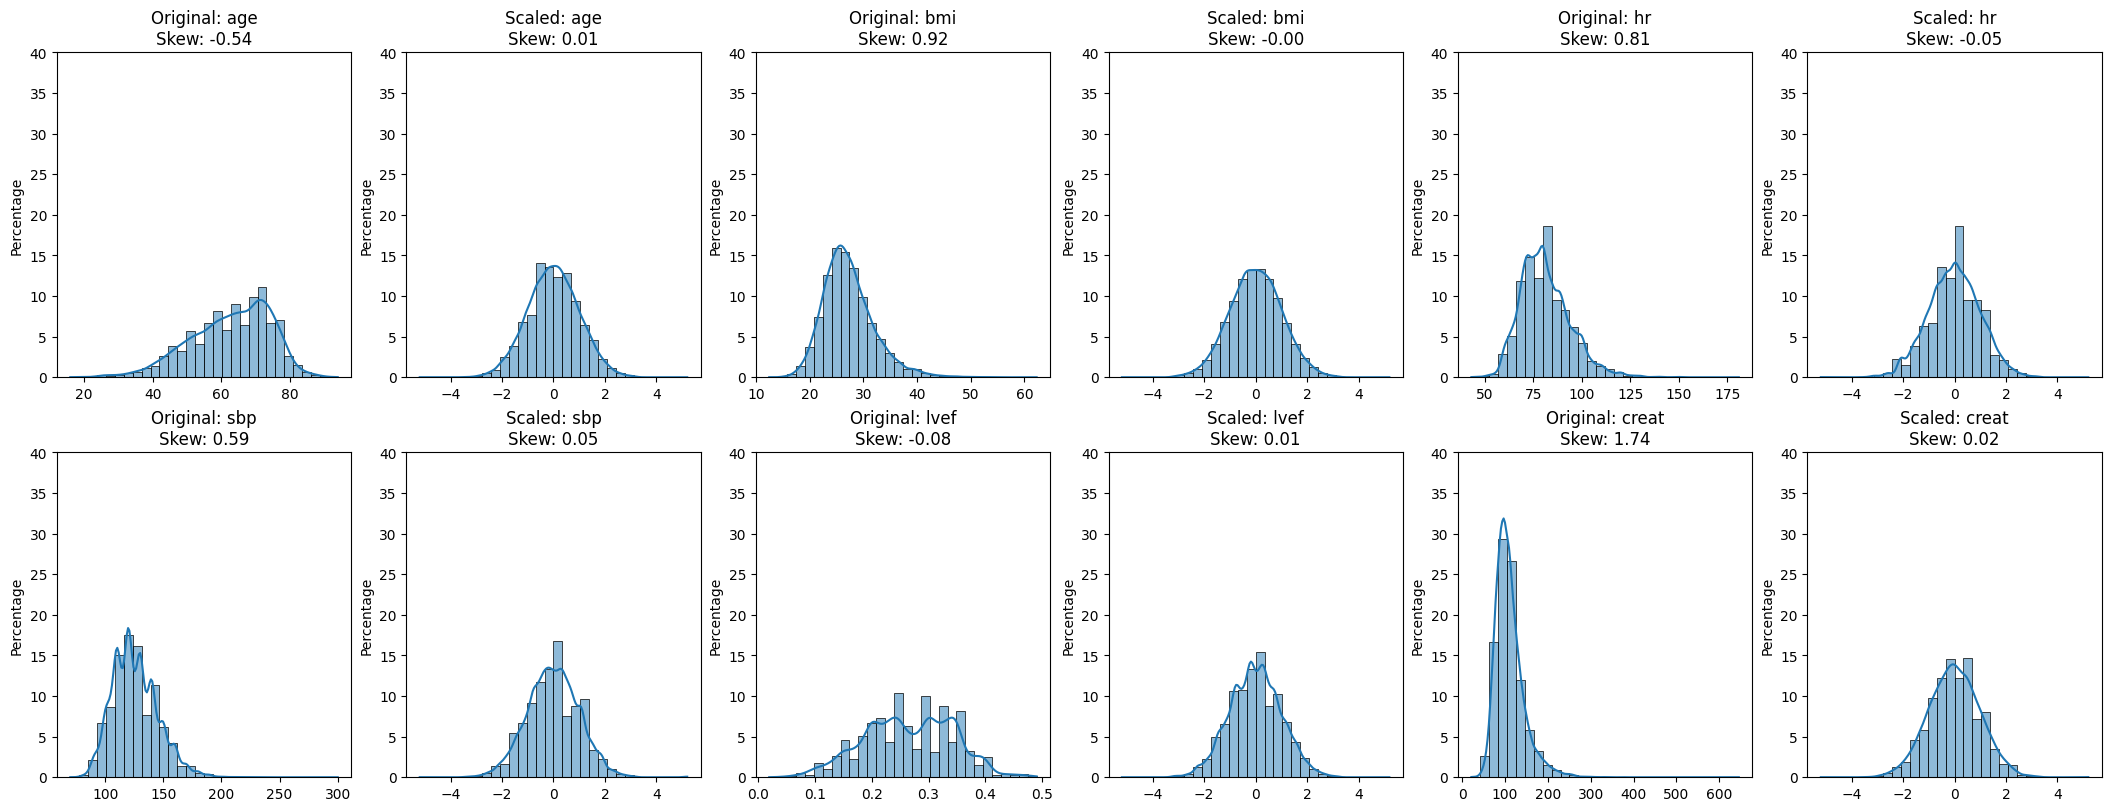

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
import math

# Step 2: Copy original data for scaling
data_to_scale = cleaned_df[numerical_cols].copy()

# Step 3: Define the transformer
pt = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42), 
     ['creat', 'bmi', 'hr', 'lvef', 'sbp', 'age']),
], remainder='passthrough')

# Step 4: Apply scaling
scaled_array = pt.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_array, columns=numerical_cols)

# Step 5: Wide layout: original and scaled side by side per variable
# Set number of columns (e.g., 6 = 3 variables × 2 plots per variable)
plots_per_row = 3  # Number of variables per row
ncols = 2 * plots_per_row  # Original + scaled per variable
nrows = math.ceil(len(numerical_cols) / plots_per_row)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3.5, nrows * 4), constrained_layout=True)

# If only one row, axes might be 1D
axes = axes.reshape(nrows, ncols)

for i, column in enumerate(numerical_cols):
    row = i // plots_per_row
    col = (i % plots_per_row) * 2

    # Original
    original_skew = skew(cleaned_df[column].dropna())
    sns.histplot(cleaned_df[column], bins=30, kde=True, stat='percent', ax=axes[row][col])
    axes[row][col].set_title(f'Original: {column}\nSkew: {original_skew:.2f}')
    axes[row][col].set_ylabel("Percentage")
    axes[row][col].set_ylim(0, 40)
    axes[row][col].set_xlabel("")

    # Scaled
    scaled_skew = skew(scaled_df[column].dropna())
    sns.histplot(scaled_df[column], bins=30, kde=True, stat='percent', ax=axes[row][col + 1])
    axes[row][col + 1].set_title(f'Scaled: {column}\nSkew: {scaled_skew:.2f}')
    axes[row][col + 1].set_ylabel("Percentage")
    axes[row][col + 1].set_ylim(0, 40)
    axes[row][col + 1].set_xlabel("")

# Save wide-format figure for PowerPoint
plt.savefig("histograms_wide_for_pptx.png", dpi=300)
plt.show()


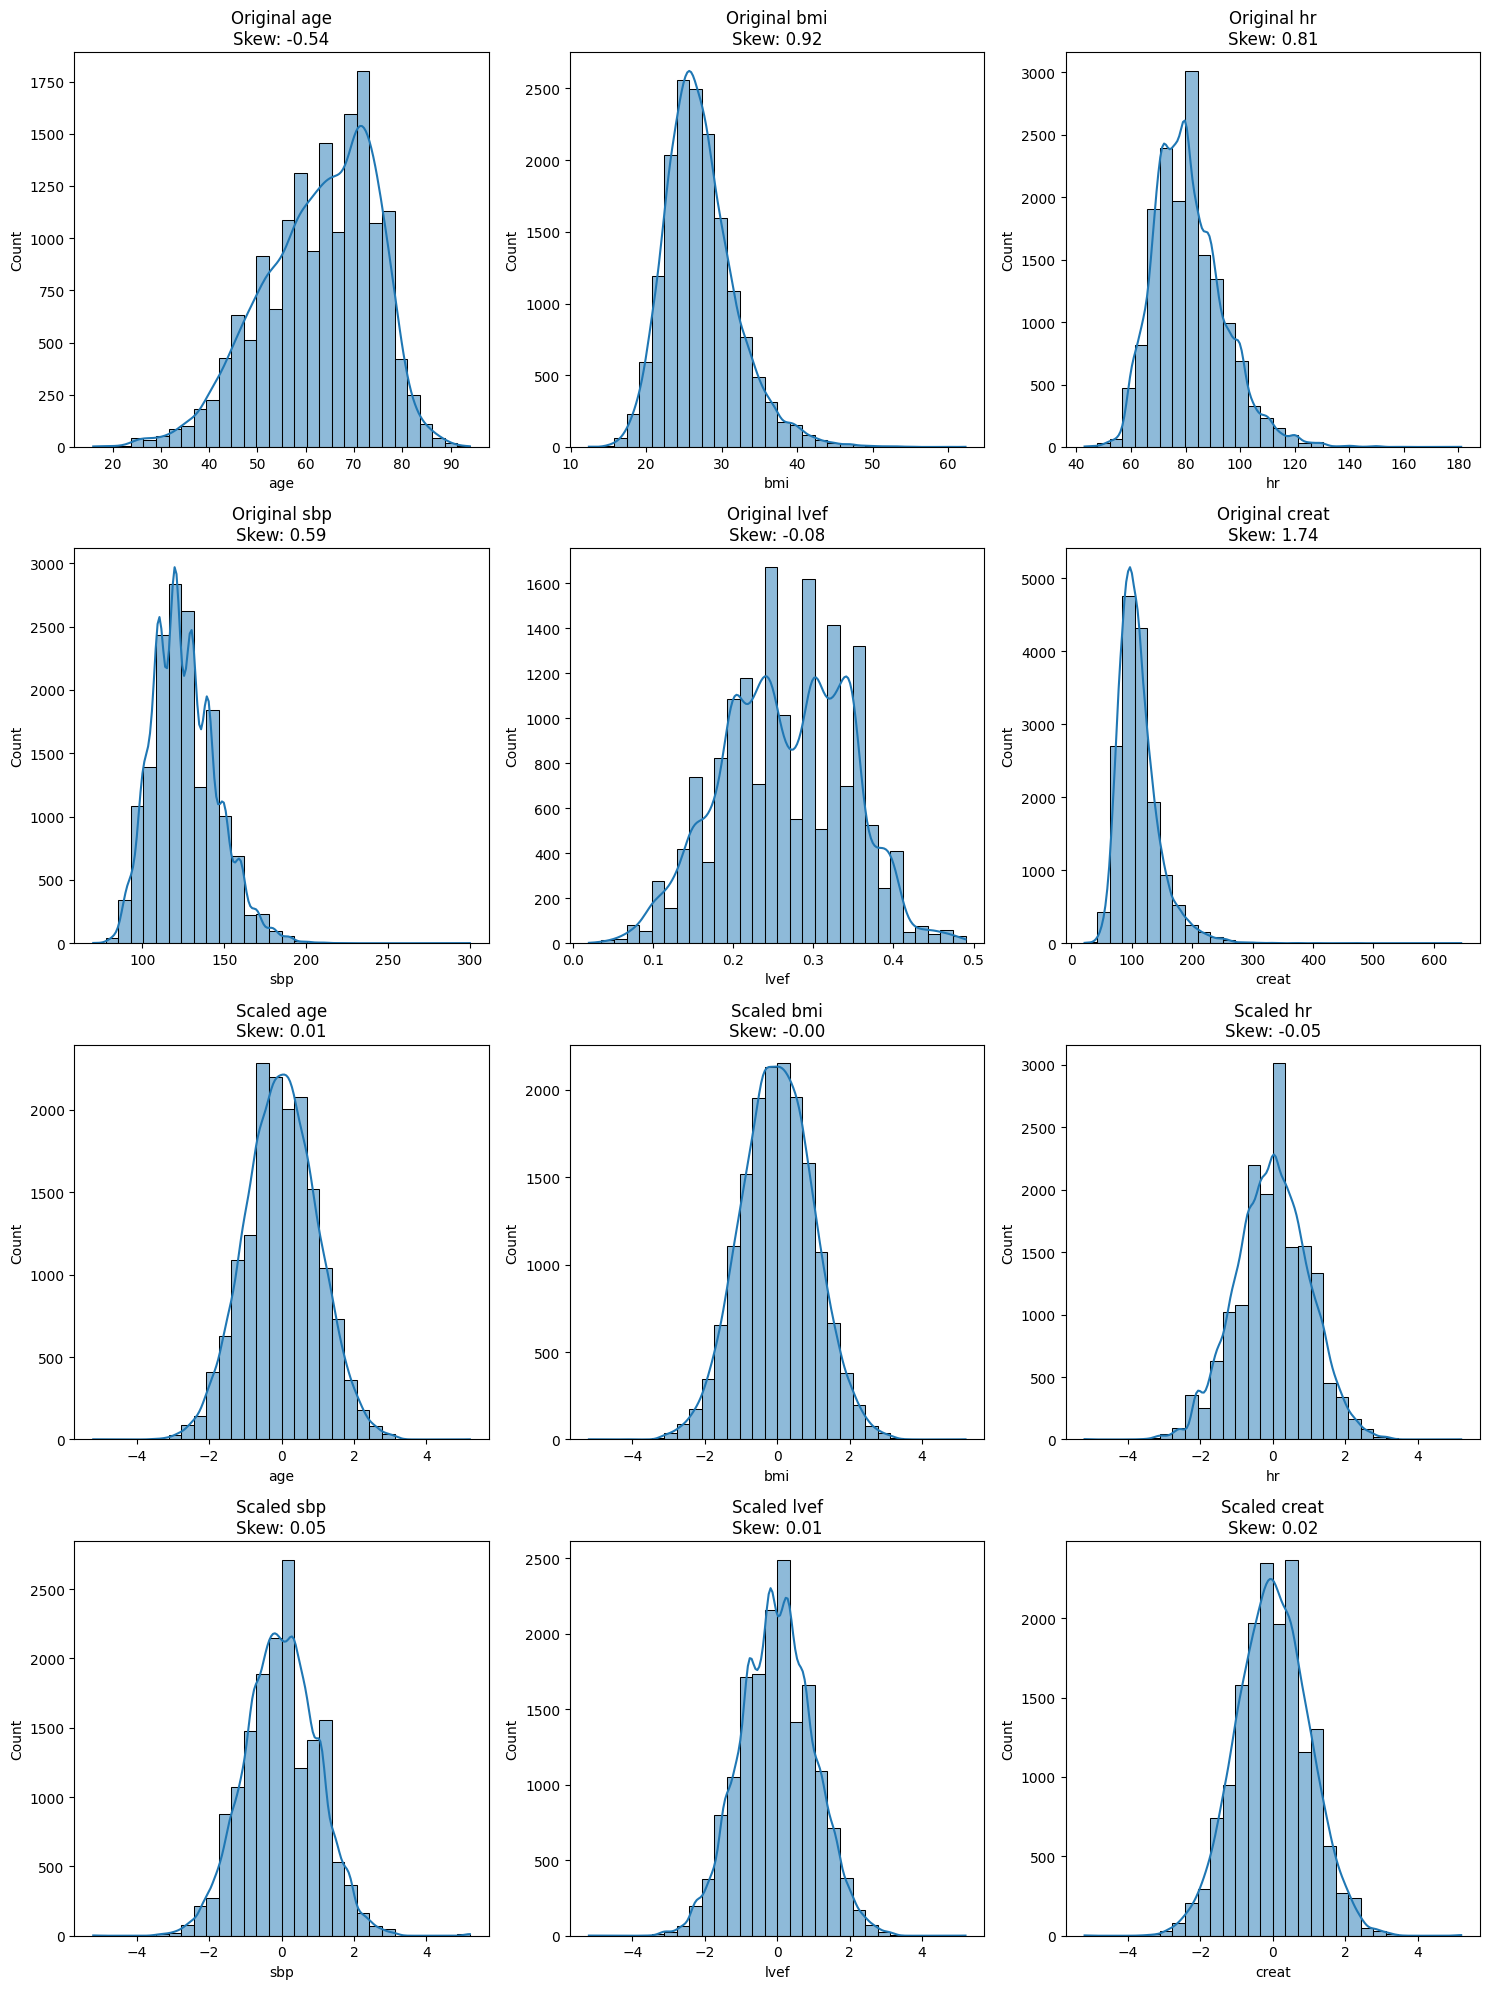

In [11]:
# Step 2: Copy original data for scaling
data_to_scale = cleaned_df[numerical_cols].copy()

# Step 3: Define the transformer
pt = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42), ['creat', 'bmi', 'hr', 'lvef', 'sbp', 'age']),
], remainder='passthrough')

# Step 4: Apply scaling
scaled_array = pt.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_array, columns=numerical_cols)

# Step 5: Plot histograms before and after scaling with skew info
ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows * 2, ncols, figsize=(ncols * 5, nrows * 5 * 2))
axes = axes.flatten()

for idx, column in enumerate(numerical_cols):
    # Original data
    original_skew = skew(cleaned_df[column].dropna())
    sns.histplot(cleaned_df[column], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Original {column}\nSkew: {original_skew:.2f}')

    # Scaled data
    scaled_skew = skew(scaled_df[column].dropna())
    sns.histplot(scaled_df[column], bins=30, kde=True, ax=axes[idx + len(numerical_cols)])
    axes[idx + len(numerical_cols)].set_title(f'Scaled {column}\nSkew: {scaled_skew:.2f}')

plt.tight_layout()
plt.savefig("eda_histograms_before_after_scaling.png", dpi=300)
plt.show()

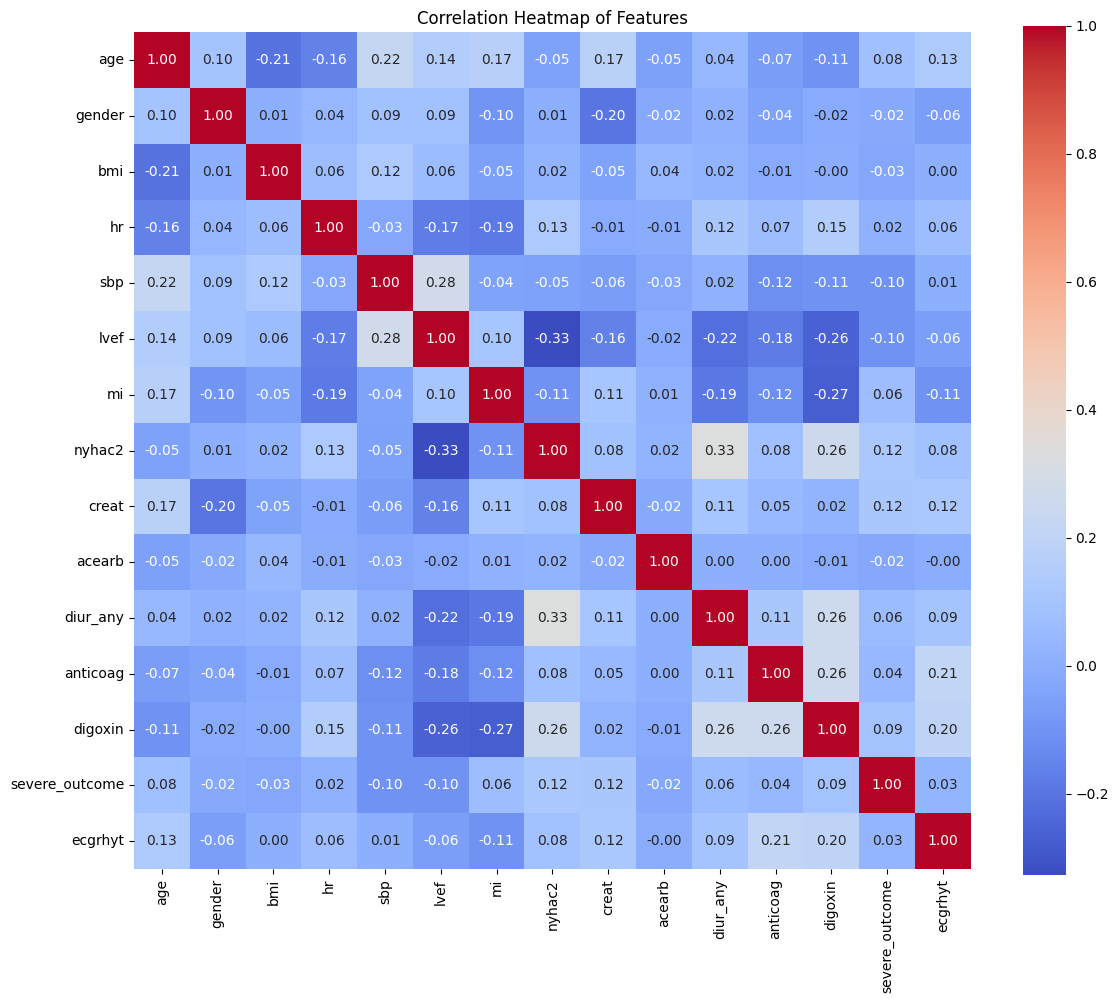

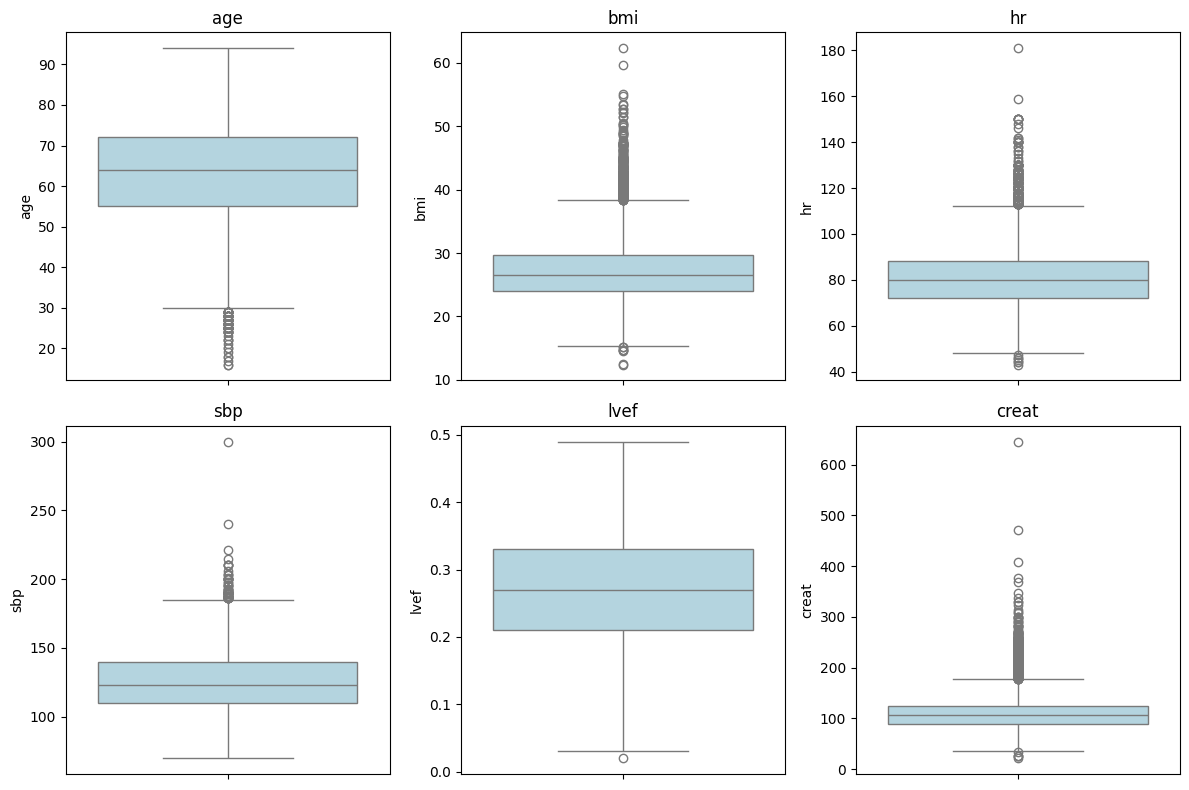

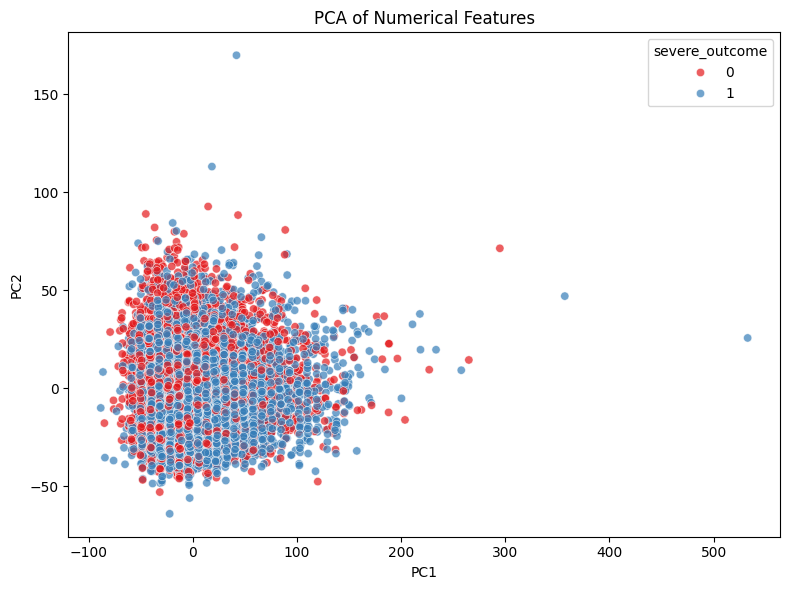

In [12]:
## EDA ##
# 2. Heatmap to see correlation between all features
corr_matrix = cleaned_df[all_cols].corr()

# Create mask for the upper triangle (including diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": .5},)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
#plt.savefig("eda_correlation_heatmap_lower_triangle.png", dpi=300)
plt.show()

# 3. Boxplot for all numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=cleaned_df[col], color='lightblue')
    plt.title(col)
    plt.tight_layout()
plt.savefig("eda_boxplots.png", dpi=300)
plt.show()

# 4. PCA Visualization
X = cleaned_df[numerical_cols]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['severe_outcome'] = cleaned_df['severe_outcome']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='severe_outcome', palette='Set1', alpha=0.7)
plt.title('PCA of Numerical Features')
plt.tight_layout()
plt.savefig("eda_pca_scatter.png", dpi=300)
plt.show()

/tmp/ipykernel_26952/3963711922.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.71641515 -1.24750548 -1.93448884 ... -0.17400458 -1.71641515
 -0.17400458]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, :] = transformed
/tmp/ipykernel_26952/3963711922.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.77483284  0.03890144  0.62109893 ...  0.3548223  -2.04311514
  2.09652058]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, :] = transformed
/tmp/ipykernel_26952/3963711922.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.06654121 -0.7630301  -0.7630301  ... -0.03387984  0.29529601
 -1.77392186]' has dtype incompatible with int64, please e


🔍 K-S Test for Normality (qt):
age        | KS Stat = 0.0239 | p-value = 0.0000 ❌ Not Normal (reject H0)
bmi        | KS Stat = 0.0047 | p-value = 0.8613 ✅ Likely Normal (fail to reject H0)
hr         | KS Stat = 0.0417 | p-value = 0.0000 ❌ Not Normal (reject H0)
sbp        | KS Stat = 0.0507 | p-value = 0.0000 ❌ Not Normal (reject H0)
lvef       | KS Stat = 0.0392 | p-value = 0.0000 ❌ Not Normal (reject H0)
creat      | KS Stat = 0.0216 | p-value = 0.0000 ❌ Not Normal (reject H0)

📈 Q-Q Plots (qt):


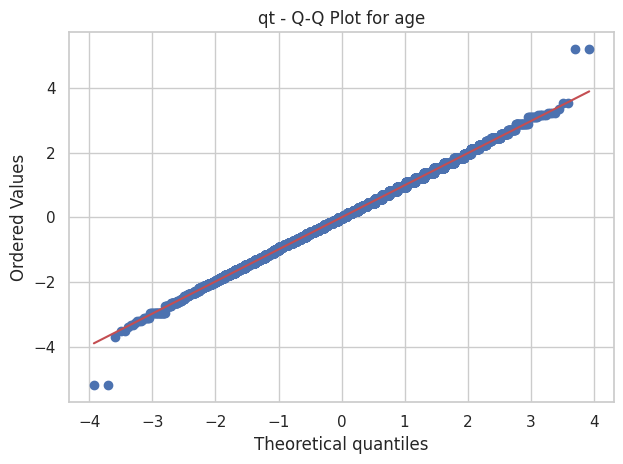

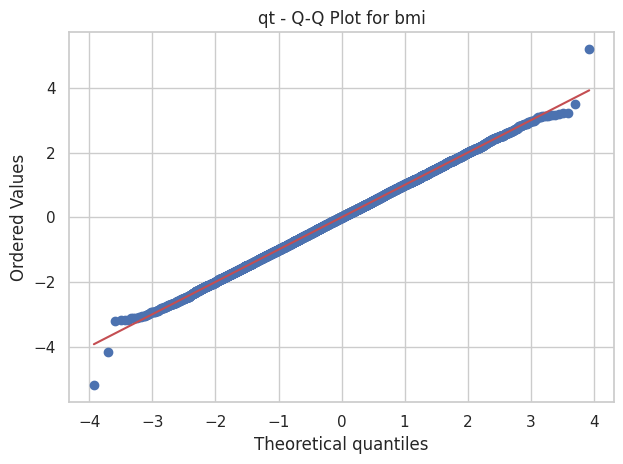

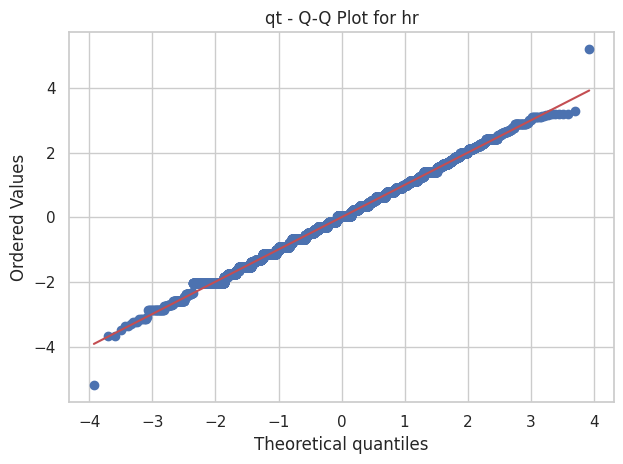

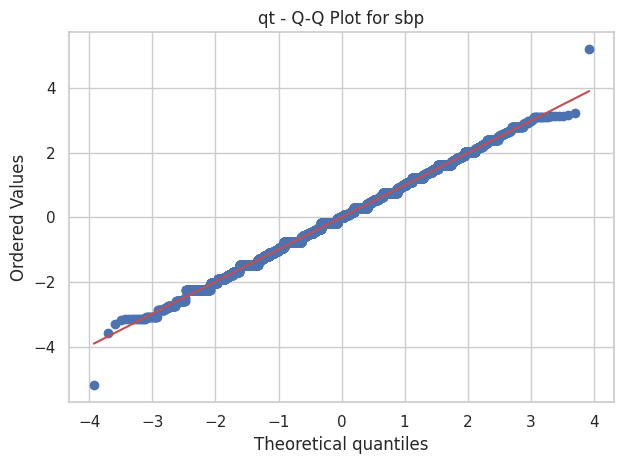

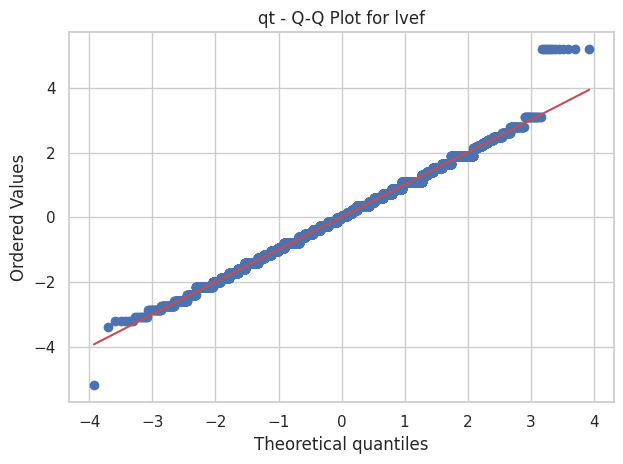

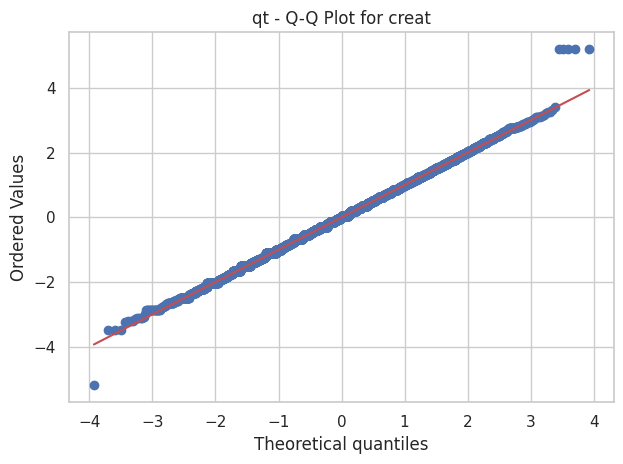


📊 Anderson-Darling Test:

age:
  AD Statistic = 6.0649
  Critical Values:
    15.0%: 0.5760 ❌
    10.0%: 0.6560 ❌
     5.0%: 0.7870 ❌
     2.5%: 0.9180 ❌
     1.0%: 1.0920 ❌

bmi:
  AD Statistic = 0.2462
  Critical Values:
    15.0%: 0.5760 ✅
    10.0%: 0.6560 ✅
     5.0%: 0.7870 ✅
     2.5%: 0.9180 ✅
     1.0%: 1.0920 ✅

hr:
  AD Statistic = 13.0269
  Critical Values:
    15.0%: 0.5760 ❌
    10.0%: 0.6560 ❌
     5.0%: 0.7870 ❌
     2.5%: 0.9180 ❌
     1.0%: 1.0920 ❌

sbp:
  AD Statistic = 17.6675
  Critical Values:
    15.0%: 0.5760 ❌
    10.0%: 0.6560 ❌
     5.0%: 0.7870 ❌
     2.5%: 0.9180 ❌
     1.0%: 1.0920 ❌

lvef:
  AD Statistic = 16.2741
  Critical Values:
    15.0%: 0.5760 ❌
    10.0%: 0.6560 ❌
     5.0%: 0.7870 ❌
     2.5%: 0.9180 ❌
     1.0%: 1.0920 ❌

creat:
  AD Statistic = 2.8377
  Critical Values:
    15.0%: 0.5760 ❌
    10.0%: 0.6560 ❌
     5.0%: 0.7870 ❌
     2.5%: 0.9180 ❌
     1.0%: 1.0920 ❌


In [35]:
# Scaling data to determine best Scaler method (Conclusion: YeoJohnson is best based on Q-Q plots)

# Original DataFrame
original_df = cleaned_df[numerical_cols].copy()

# Scalers
scalers = {
#    'StandardScaler': StandardScaler(),
 #   'RobustScaler': RobustScaler(),
  #  'MinMaxScaler': MinMaxScaler(),
#    'YeoJohnson': PowerTransformer(method='yeo-johnson', standardize=True),
'qt': QuantileTransformer(output_distribution='normal')}

# Dictionary to store transformed DataFrames
scaled_dfs = {}

for name, scaler in scalers.items():
    transformed = scaler.fit_transform(original_df)
    df_scaled = original_df.copy()
    df_scaled.loc[:, :] = transformed
    scaled_dfs[name] = df_scaled


# Iterate through each scaling method's DataFrame
for scaler_name, df_to_test in scaled_dfs.items():
    print(f"\n🔍 K-S Test for Normality ({scaler_name}):")
    for col in numerical_cols:
        data = df_to_test[col].dropna()
        ks_stat, p_value = kstest(data, 'norm')
        print(f"{col:10} | KS Stat = {ks_stat:.4f} | p-value = {p_value:.4f} ", end='')
        if p_value > 0.05:
            print("✅ Likely Normal (fail to reject H0)")
        else:
            print("❌ Not Normal (reject H0)")


    # Q-Q Plots
    print(f"\n📈 Q-Q Plots ({scaler_name}):")
    for col in numerical_cols:
        plt.figure()
        probplot(df_to_test[col], dist="norm", plot=plt)
        plt.title(f"{scaler_name} - Q-Q Plot for {col}")
        plt.tight_layout()
        plt.show()

        from scipy.stats import anderson

# Anderson-Darling test
    print("\n📊 Anderson-Darling Test:")
    for col in numerical_cols:
        data = df_scaled[col].dropna()
        result = anderson(data, dist='norm')
        print(f"\n{col}:")
        print(f"  AD Statistic = {result.statistic:.4f}")
        print("  Critical Values:")
        for sl, cv in zip(result.significance_level, result.critical_values):
            status = "✅" if result.statistic < cv else "❌"
            print(f"    {sl:>4.1f}%: {cv:.4f} {status}")


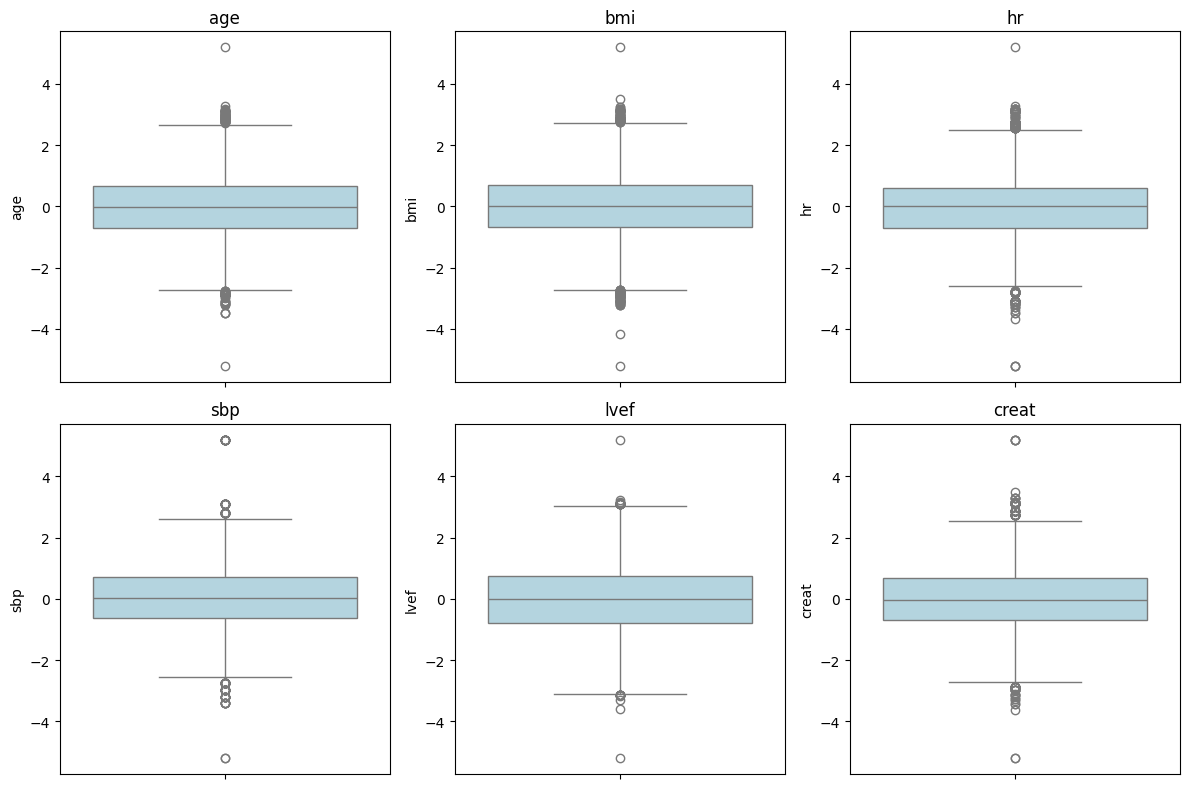

In [13]:
## EDA After Scaling ##

# Boxplots for all numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=scaled_df[col], color='lightblue')
    plt.title(col)
    plt.tight_layout()

plt.savefig("scaled_feature_boxplots.png", dpi=300)
plt.show()

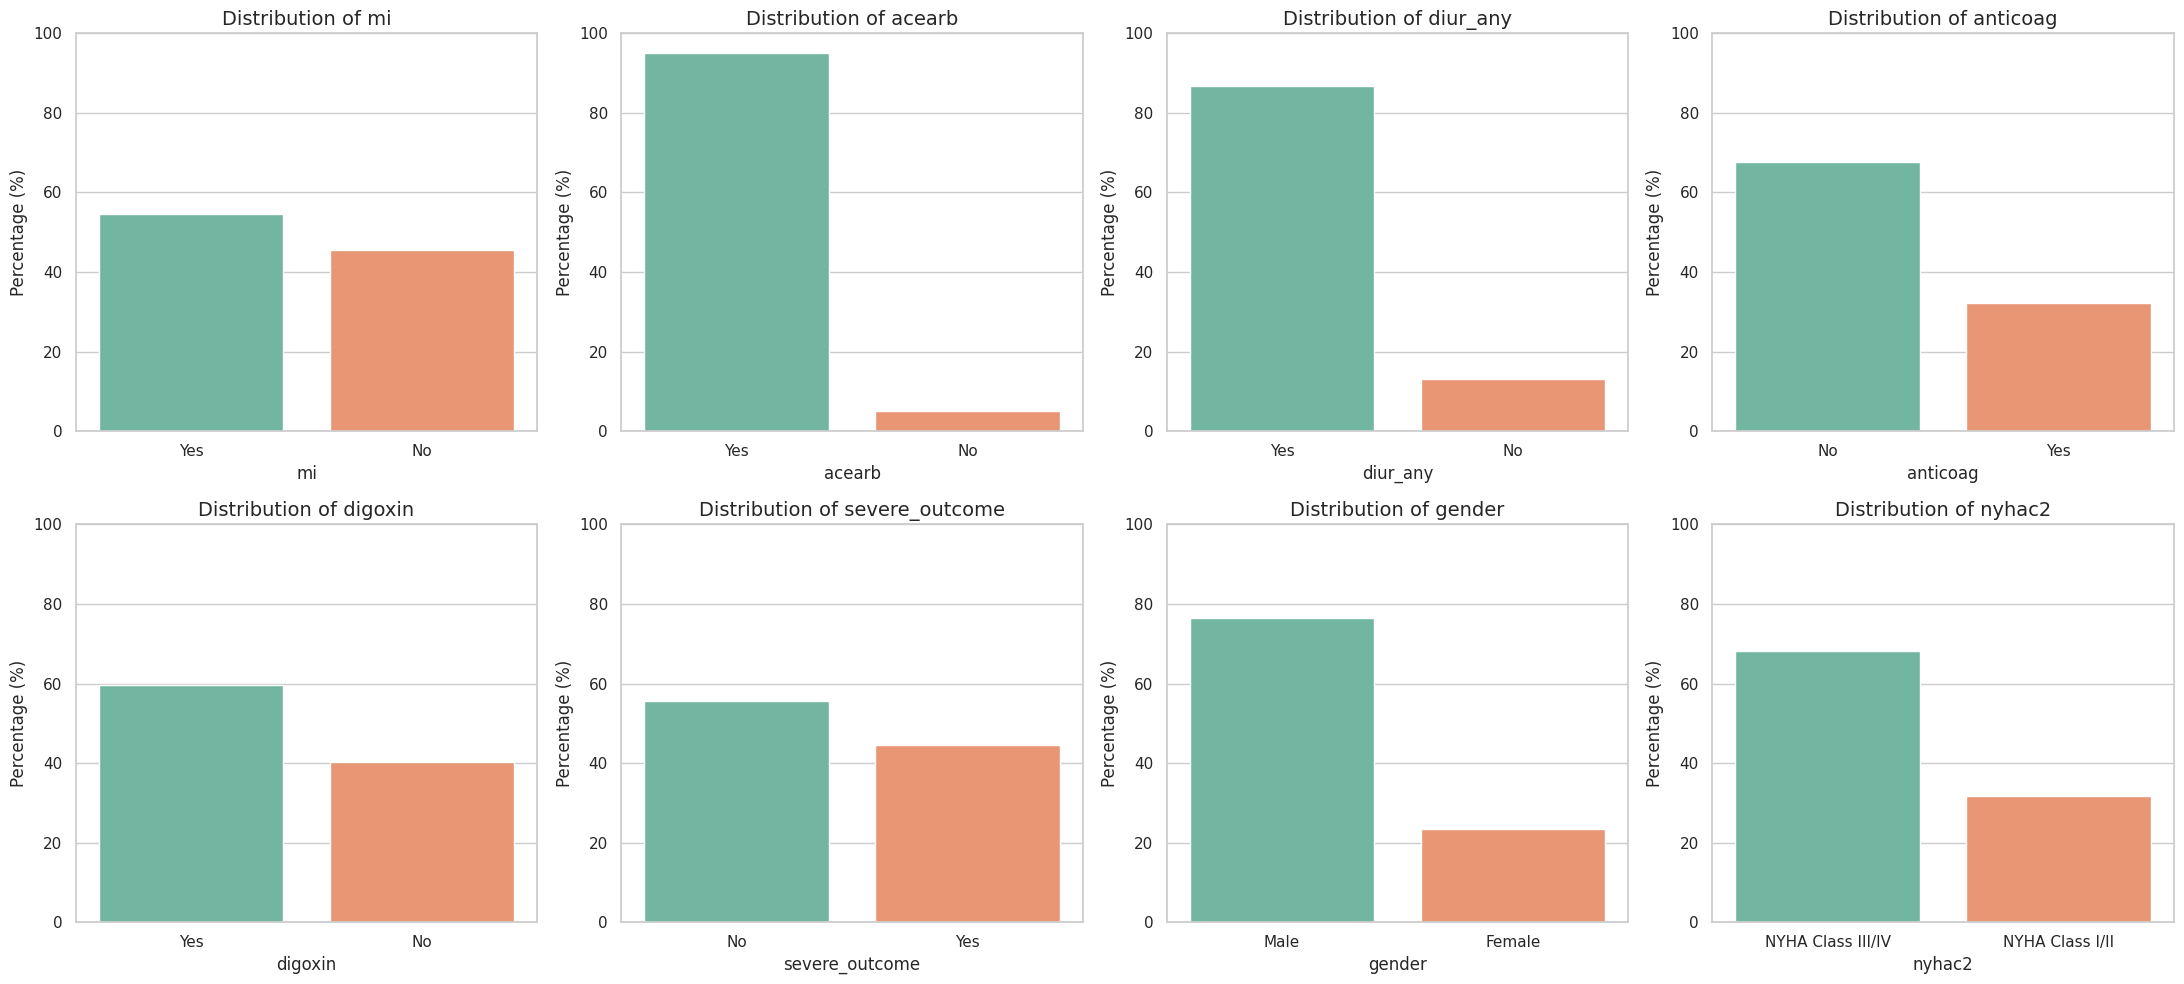

In [67]:
# For binary class columns (0 → 'No', 1 → 'Yes')
binary_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome']
for col in binary_cols:
    cleaned_df[col] = cleaned_df[col].map({0: 'No', 1: 'Yes'})

# For NYHA Class
cleaned_df['nyhac2'] = cleaned_df['nyhac2'].map({
    0: 'NYHA Class I/II',
    1: 'NYHA Class III/IV'})

# For gender
cleaned_df['gender'] = cleaned_df['gender'].map({
    0: 'Male',
    1: 'Female'})

# Set plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    # Calculate percentage distribution
    percent_df = (
        cleaned_df[col]
        .value_counts(normalize=True)
        .rename_axis(col)
        .reset_index(name='percentage'))
    percent_df['percentage'] *= 100
    sns.barplot(data=percent_df, x=col, y='percentage', ax=ax, palette='Set2', hue=col)
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 100)  # Consistent scale across all plots
    ax.tick_params(axis='x')

# Hide any unused axes
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("eda_categorical_values.png", dpi=400)
plt.show()

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

# Set up output directory
output_dir = "study_distributions"
os.makedirs(output_dir, exist_ok=True)

# Seaborn theme
sns.set(style="whitegrid")

# Variable types
continuous_vars = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_vars = ['mi_label', 'acearb_label', 'diur_any_label', 'anticoag_label',
                    'digoxin_label', 'nyhac2_label', 'gender_label', 'ecgrhyt_label']

# --- Plot and save continuous variables ---
for var in continuous_vars:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=cleaned_df, x='study', y=var)
    plt.title(f'Distribution of {var} by Study')
    plt.xticks(rotation=45)
    plt.tight_layout()
    filepath = os.path.join(output_dir, f"{var}_boxplot.png")
    plt.savefig(filepath)
    plt.close()

# --- Plot and save categorical variables as stacked bar charts ---
for var in categorical_vars:
    plt.figure(figsize=(10, 5))
    counts = cleaned_df.groupby(['study', var]).size().reset_index(name='count')
    totals = counts.groupby('study')['count'].transform('sum')
    counts['percent'] = 100 * counts['count'] / totals

    sns.barplot(data=counts, x='study', y='percent', hue=var)
    plt.title(f'Distribution of {var.replace("_label", "")} by Study')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.legend(title=var.replace("_label", ""))
    plt.ylim(0, 100)  # Force y-axis from 0 to 100%
    plt.tight_layout()
    filepath = os.path.join(output_dir, f"{var}_barplot.png")
    plt.savefig(filepath)
    plt.close()

# --- Zip all the saved figures ---
shutil.make_archive("study_distributions", 'zip', output_dir)
print("✅ All plots saved and zipped into study_distributions.zip")

✅ All plots saved and zipped into study_distributions.zip


In [55]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil

# Set seaborn theme
sns.set(style="whitegrid")

# Output directory
output_dir = "study_distributions"
os.makedirs(output_dir, exist_ok=True)

# Variables
continuous_vars = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_vars = ['mi', 'acearb', 'diur_any',
                    'anticoag', 'digoxin', 'nyhac2',
                    'gender', 'ecgrhyt']

# Label map to nice plot titles
label_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure (mmHg)',
    'hr': 'Heart rate (bpm)',
    'lvef': 'Left ventricular ejection fraction (%)',
    'creat': 'Creatinine (μmol/L)',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index (kg/m²)',
    'age': 'Age (years)',
    'gender': 'Gender',
    'ecgrhyt': 'ECG rhythm'
}


# --- Plot all categorical variables in one figure ---
fig_cat, axs_cat = plt.subplots(2, 4, figsize=(24, 12))  # 4 columns x 2 rows
axs_cat = axs_cat.flatten()

for i, var in enumerate(categorical_vars):
    ax = axs_cat[i]
    counts = cleaned_df.groupby(['study', var]).size().reset_index(name='count')
    totals = counts.groupby('study')['count'].transform('sum')
    counts['percent'] = 100 * counts['count'] / totals

    sns.barplot(data=counts, x='study', y='percent', hue=var, ax=ax)
    ax.set_title(label_map.get(var, var), fontsize=14, fontweight='bold')
    ax.set_xlabel('Study')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 100)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='', fontsize=8, loc='upper right')

# Remove unused subplots if any
for j in range(len(categorical_vars), len(axs_cat)):
    fig_cat.delaxes(axs_cat[j])

fig_cat.tight_layout()
cat_plot_path = os.path.join(output_dir, "categorical_combined.png")
fig_cat.savefig(cat_plot_path, dpi=300)
plt.close(fig_cat)

# --- Plot all continuous variables in one figure ---
fig_cont, axs_cont = plt.subplots(2, 3, figsize=(18, 10))  # 3 columns x 2 rows
axs_cont = axs_cont.flatten()

for i, var in enumerate(continuous_vars):
    ax = axs_cont[i]
    sns.boxplot(data=cleaned_df, x='study', y=var, ax=ax)
    ax.set_title(label_map.get(var, var), fontsize=14, fontweight='bold')

    ax.set_xlabel('Study')
    ax.set_ylabel(label_map.get(var, var))  # add units on y-axis
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Remove unused subplots if any
for j in range(len(continuous_vars), len(axs_cont)):
    fig_cont.delaxes(axs_cont[j])

fig_cont.tight_layout()
cont_plot_path = os.path.join(output_dir, "continuous_combined.png")
fig_cont.savefig(cont_plot_path, dpi=300)
plt.close(fig_cont)

# --- Zip the output directory ---
shutil.make_archive("study_distributions", 'zip', output_dir)
print("✅ All combined plots saved and zipped into 'study_distributions.zip'")

/tmp/ipykernel_12001/1511885007.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/1511885007.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/1511885007.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/1511885007.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/1511885007.py:54: UserWarning: set_tick

✅ All combined plots saved and zipped into 'study_distributions.zip'


/tmp/ipykernel_12001/1930588099.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percent_df, x=col, y='percentage', ax=ax, palette='Set2')
/tmp/ipykernel_12001/1930588099.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percent_df, x=col, y='percentage', ax=ax, palette='Set2')
/tmp/ipykernel_12001/1930588099.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percent_df, x=col, y='percentage', ax=ax, palette='Set2')
/tmp/ipykernel_12001/1930588099.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is de

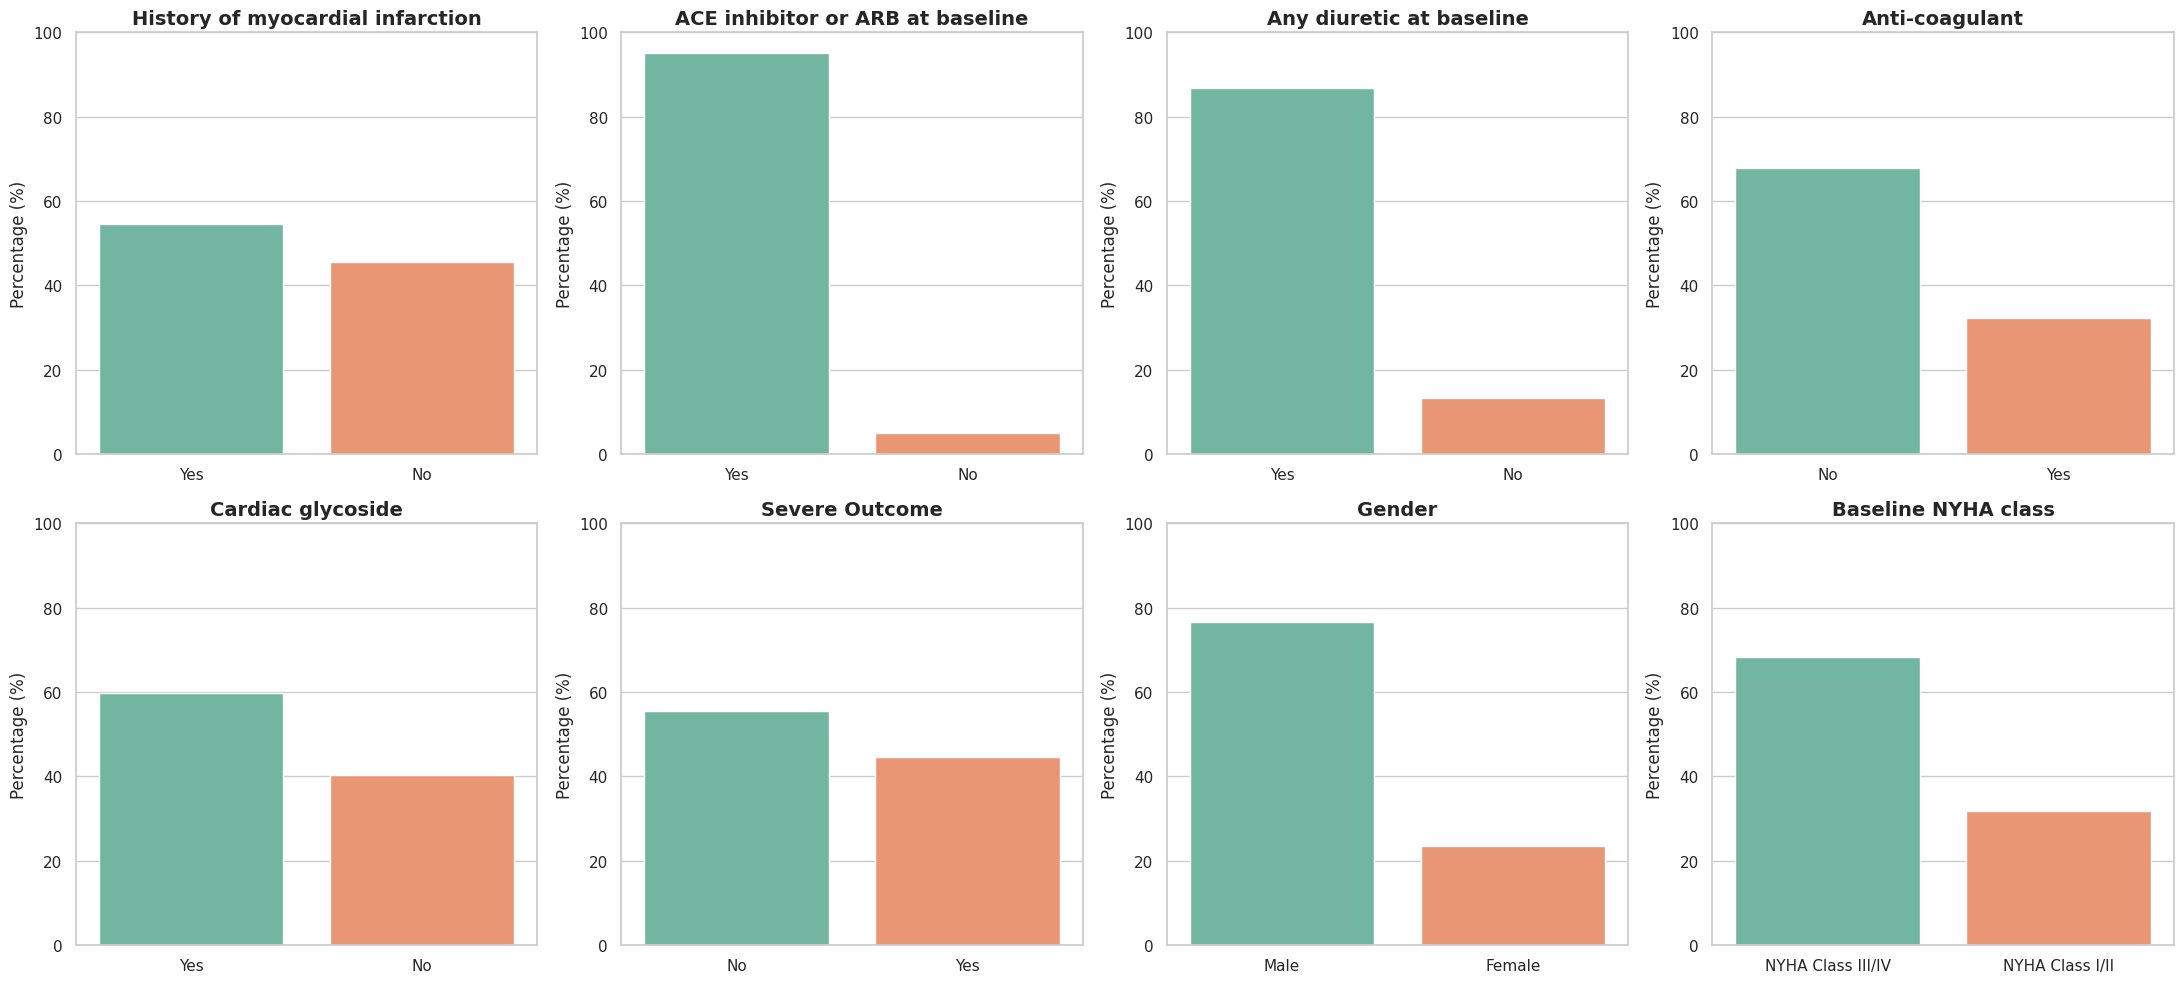

In [53]:
# For binary class columns (0 → 'No', 1 → 'Yes')
binary_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome']
for col in binary_cols:
    cleaned_df[col] = cleaned_df[col].map({0: 'No', 1: 'Yes'})

# For NYHA Class
cleaned_df['nyhac2'] = cleaned_df['nyhac2'].map({
    0: 'NYHA Class I/II',
    1: 'NYHA Class III/IV'})

# For gender
cleaned_df['gender'] = cleaned_df['gender'].map({
    0: 'Male',
    1: 'Female'})

label_map = {
    'mi': 'History of myocardial infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure (mmHg)',
    'hr': 'Heart rate (bpm)',
    'lvef': 'Left ventricular ejection fraction (%)',
    'creat': 'Creatinine (μmol/L)',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index (kg/m²)',
    'age': 'Age (years)',
    'gender': 'Gender',
    'ecgrhyt': 'ECG rhythm',
    'severe_outcome': 'Severe Outcome'
}

# Set plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    # Calculate percentage distribution
    percent_df = (
        cleaned_df[col]
        .value_counts(normalize=True)
        .rename_axis(col)
        .reset_index(name='percentage'))
    percent_df['percentage'] *= 100

    sns.barplot(data=percent_df, x=col, y='percentage', ax=ax, palette='Set2')
    ax.set_title(label_map.get(col, col), fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 100)  # Consistent scale across all plots
    ax.tick_params(axis='x')

# Hide any unused axes
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("eda_categorical_values.png", dpi=400)
plt.show()

In [60]:
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string

# --- Example load: replace with your actual cleaned_df ---
# cleaned_df = pd.read_csv("your_data.csv")

# --- Seaborn theme ---
sns.set_theme(style="whitegrid", palette="pastel")

# --- Variables ---
continuous_vars = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_vars = ['mi', 'acearb', 'diur_any',
                    'anticoag', 'digoxin', 'nyhac2', 'gender']  # excluded 'ecgrhyt'

label_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure (mmHg)',
    'hr': 'Heart rate (bpm)',
    'lvef': 'Left ventricular ejection fraction (%)',
    'creat': 'Creatinine (μmol/L)',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index (kg/m²)',
    'age': 'Age (years)',
    'gender': 'Gender'
}

# --- All variables ---
all_vars = categorical_vars + continuous_vars
n_vars = len(all_vars)

# --- Determine consistent study order ---
study_order = sorted(cleaned_df['study'].unique())

# --- Plotting ---
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axs = axs.flatten()
letters = list(string.ascii_uppercase)

for i, var in enumerate(all_vars):
    ax = axs[i]
    letter = letters[i]
    
    if var in categorical_vars:
        counts = cleaned_df.groupby(['study', var]).size().reset_index(name='count')
        totals = counts.groupby('study')['count'].transform('sum')
        counts['percent'] = 100 * counts['count'] / totals
        
        sns.barplot(
            data=counts, x='study', y='percent', hue=var,
            ax=ax, order=study_order, edgecolor="0.2"
        )
        ax.set_ylabel("Percentage (%)")
        ax.set_ylim(0, 100)
        ax.legend_.remove()
    else:
        sns.boxplot(
            data=cleaned_df, x='study', y=var,
            ax=ax, order=study_order
        )
        ax.set_ylabel(label_map.get(var, var))
    
    ax.set_title(f"({letter}) {label_map.get(var, var)}", fontsize=13, weight='bold')
    ax.set_xlabel("Study")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


# --- Remove unused subplots ---
for j in range(n_vars, len(axs)):
    fig.delaxes(axs[j])

# --- Super title & layout ---
fig.suptitle("Distributions of Baseline Characteristics by RCT",
             fontsize=18, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.96])

# --- Save ---
final_plot_path = os.path.join(output_dir, "combined_baseline_characteristics.png")
fig.savefig(final_plot_path, dpi=300)
plt.close(fig)

print(f"✅ Combined plot saved at {final_plot_path}")

/tmp/ipykernel_12001/158697482.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/158697482.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/158697482.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/158697482.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_12001/158697482.py:73: UserWarning: set_ticklabel

✅ Combined plot saved at study_distributions/combined_baseline_characteristics.png


/tmp/ipykernel_90690/2957367487.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_df, x='study', y=var, ax=ax,
/tmp/ipykernel_90690/2957367487.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_90690/2957367487.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_df, x='study', y=var, ax=ax,
/tmp/ipykernel_90690/2957367487.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabel

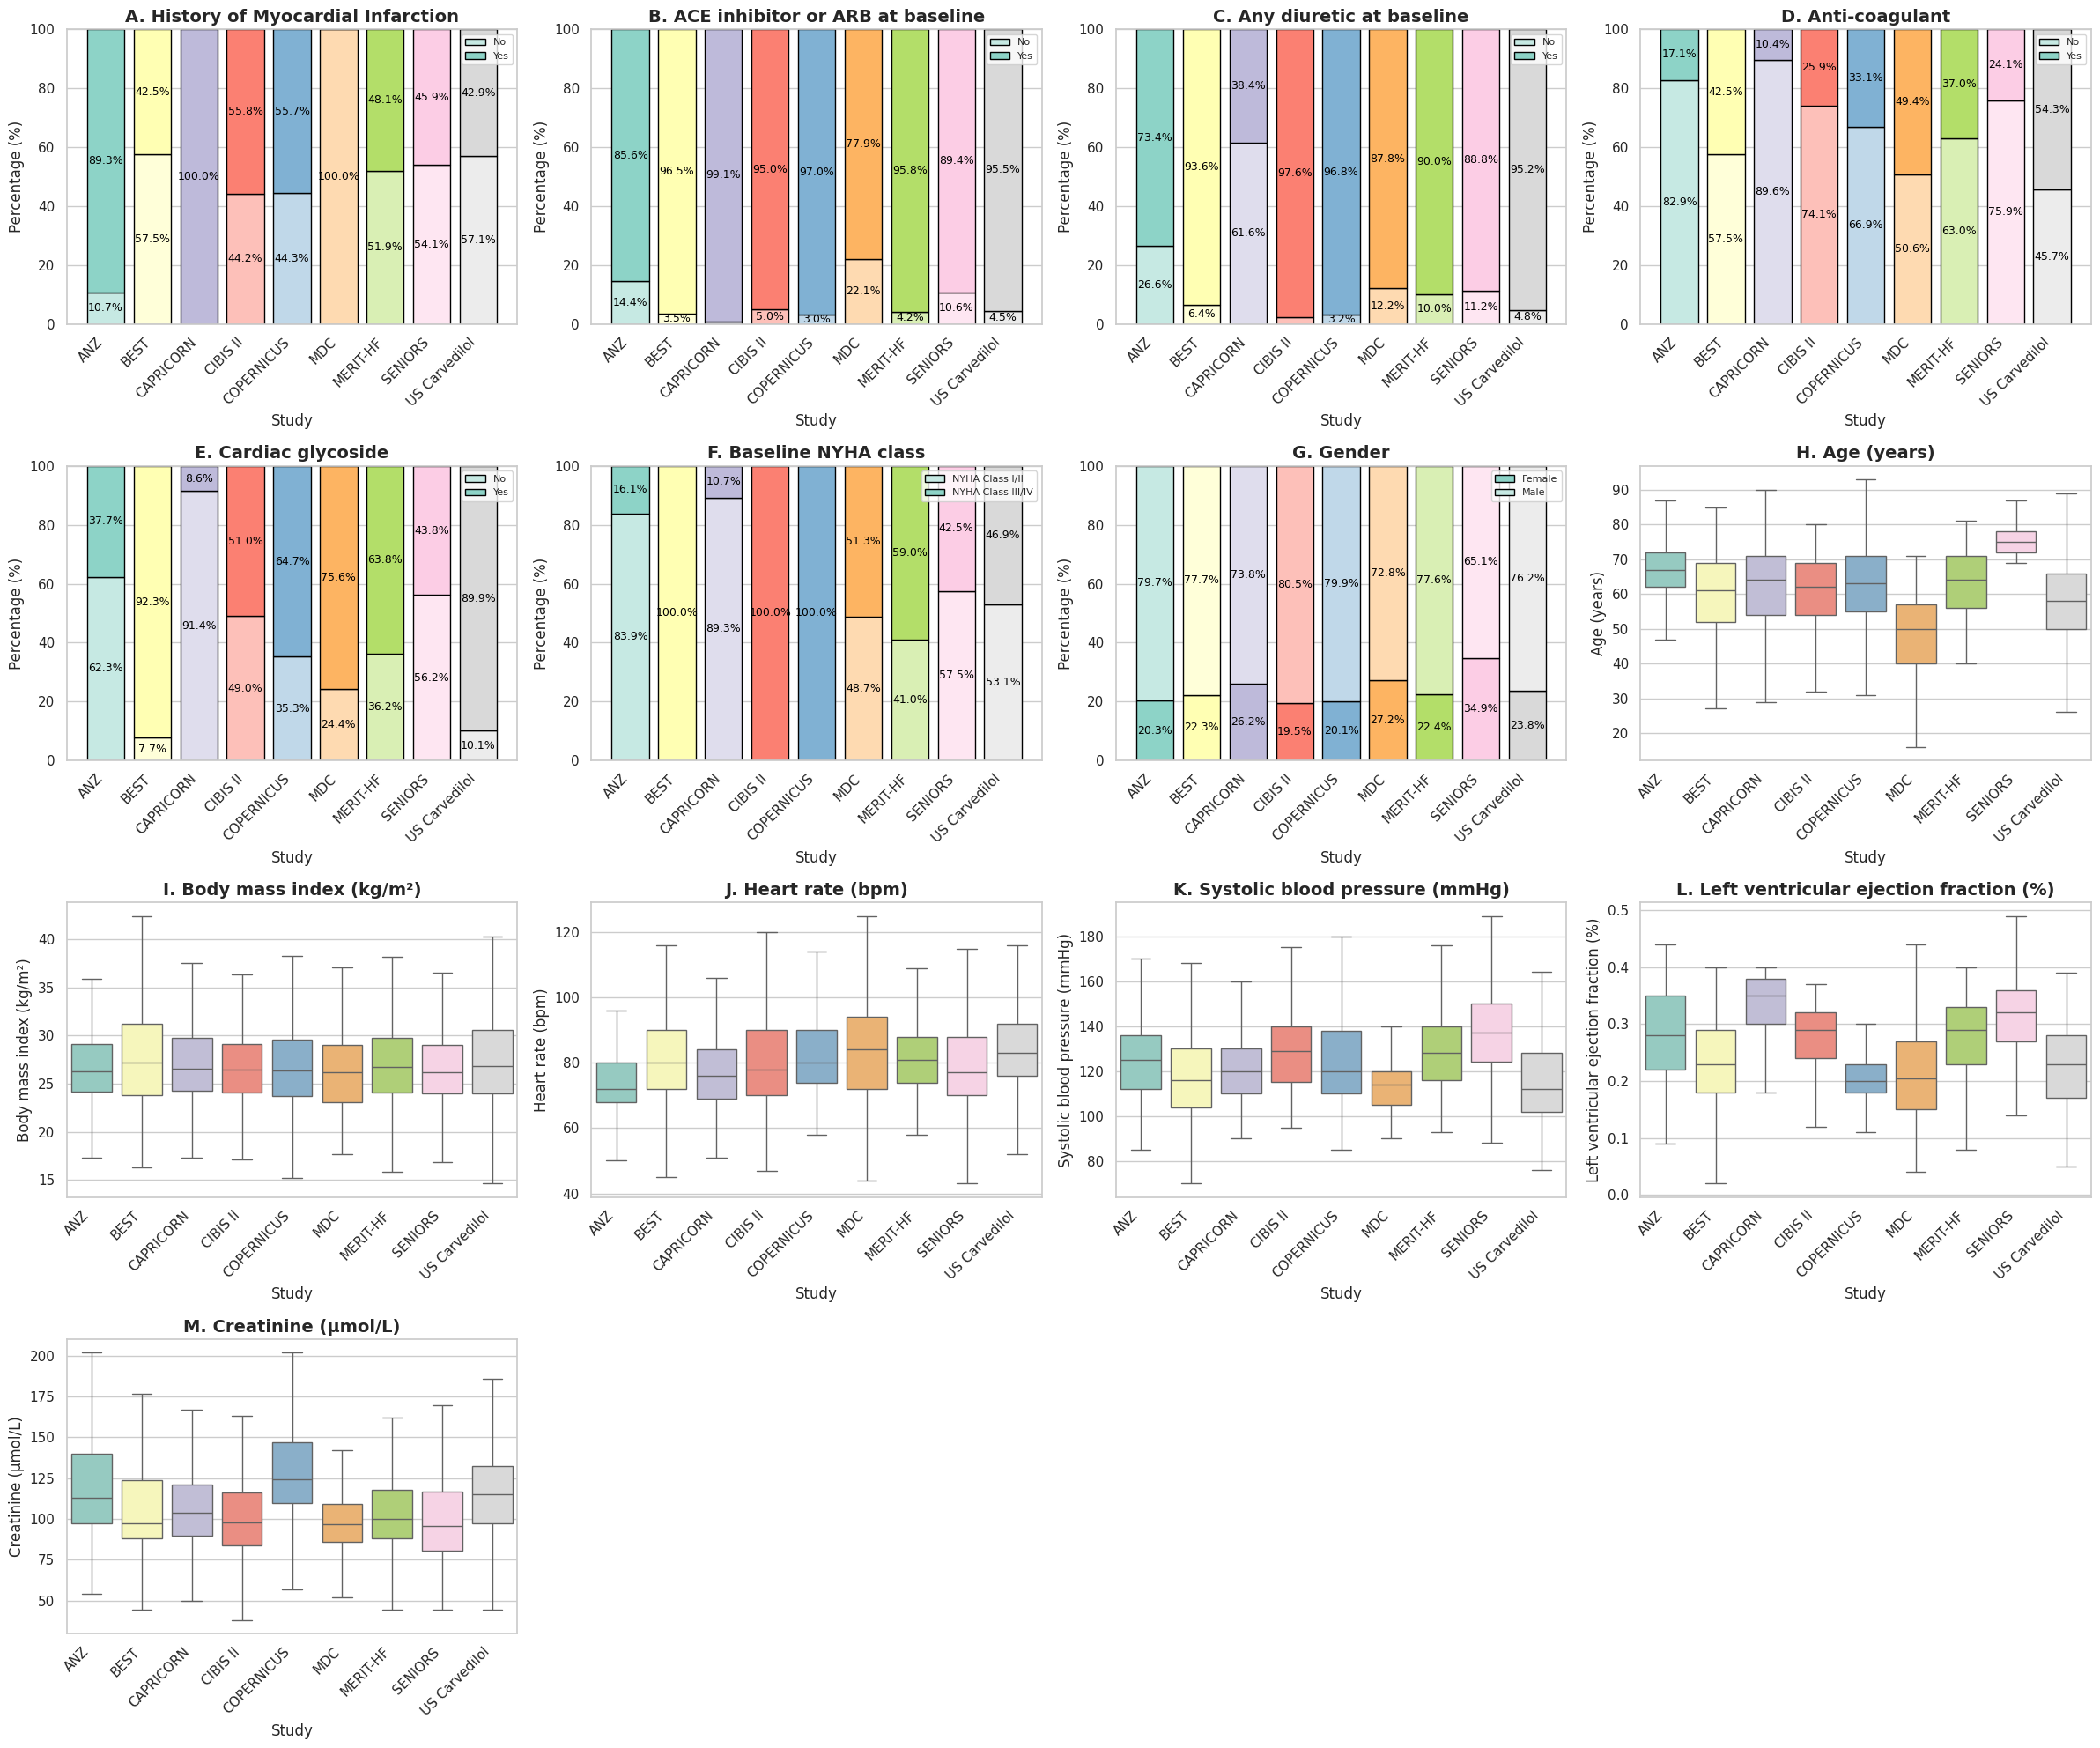

Combined figure saved to study_distributions/combined_stacked_categorical_continuous_same_study_colors.png


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from matplotlib.colors import to_rgba

sns.set_theme(style="whitegrid")

output_dir = "study_distributions"
os.makedirs(output_dir, exist_ok=True)

# ---------- PREP ----------

# --- Variables ---
continuous_vars = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_vars = ['mi', 'acearb', 'diur_any',
                    'anticoag', 'digoxin', 'nyhac2', 'gender']  # excluded 'ecgrhyt'

label_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure (mmHg)',
    'hr': 'Heart rate (bpm)',
    'lvef': 'Left ventricular ejection fraction (%)',
    'creat': 'Creatinine (μmol/L)',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index (kg/m²)',
    'age': 'Age (years)',
    'gender': 'Gender'
}


# Make a copy to avoid modifying original df
cleaned_df = cleaned_df.copy()

# Map gender and nyhac2 early and only if they exist
if 'gender' in cleaned_df.columns:
    cleaned_df['gender'] = cleaned_df['gender'].map({0: 'Male', 1: 'Female'}).astype(str)

if 'nyhac2' in cleaned_df.columns:
    cleaned_df['nyhac2'] = cleaned_df['nyhac2'].map({
        0: 'NYHA Class I/II',
        1: 'NYHA Class III/IV'
    }).astype(str)

# Set consistent study order and colors
study_order = sorted(cleaned_df['study'].dropna().unique())
study_palette = sns.color_palette("Set3", len(study_order))
study_color_map = dict(zip(study_order, study_palette))

# Prepare plot layout
n_cat = len(categorical_vars)
n_cont = len(continuous_vars)
total_plots = n_cat + n_cont
ncols = 4
nrows = (total_plots + ncols - 1) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
axs = axs.flatten()

letters = list(string.ascii_uppercase)
class_map = {0: 'No', 1: 'Yes'}

# ----------- PLOTTING CATEGORICAL -----------

for idx, var in enumerate(categorical_vars):
    ax = axs[idx]
    
    temp_df = cleaned_df.copy()

    # For variables like gender and nyhac2, no need to map 0/1 again
    # For others, map 0/1 to No/Yes if applicable
    if var not in ['gender', 'nyhac2']:
        if temp_df[var].dropna().isin(class_map.keys()).all():
            temp_df[var] = temp_df[var].map(class_map).astype(str)
    else:
        temp_df[var] = temp_df[var].astype(str)

    counts = temp_df.groupby(['study', var]).size().unstack(fill_value=0)
    counts = counts.reindex(study_order)
    percents = counts.div(counts.sum(axis=1), axis=0) * 100

    bottom = np.zeros(len(percents))
    
    # Stacked bars with shading by class value
    for class_val in sorted(percents.columns):
        colors = []
        for study in percents.index:
            base_color = study_color_map[study]
            # Use lighter shade for one class, darker for the other, just as example
            alpha = 0.5 if class_val.lower() in ['no', 'male', 'nyha class i/ii'] else 1.0
            rgba = to_rgba(base_color, alpha=alpha)
            blended = [c*alpha + (1-alpha)*1 for c in rgba[:3]]
            colors.append(blended)

        bars = ax.bar(percents.index, percents[class_val], bottom=bottom,
                      color=colors, edgecolor='black', label=class_val)
        
        for bar, percent_val in zip(bars, percents[class_val]):
            if percent_val > 3:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{percent_val:.1f}%",
                    ha='center', va='center',
                    fontsize=9, color='black'
                )
        bottom += percents[class_val].values

    # Add letter bullet to title
    ax.set_title(f"{letters[idx]}. {label_map.get(var, var)}", fontsize=14, fontweight='bold')
    ax.set_xlabel('Study')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(len(percents.index)))
    ax.set_xticklabels(percents.index, rotation=45, ha='right')
    ax.legend(title=None, fontsize=8, loc='upper right')


# ----------- PLOTTING CONTINUOUS -----------

for j, var in enumerate(continuous_vars, start=n_cat):
    ax = axs[j]
    sns.boxplot(data=cleaned_df, x='study', y=var, ax=ax,
                palette=study_color_map, showfliers=False,
                order=study_order)
    
    # Add letter bullet to title
    ax.set_title(f"{letters[j]}. {label_map.get(var, var)}", fontsize=14, fontweight='bold')
    ax.set_xlabel('Study')
    ax.set_ylabel(label_map.get(var, var))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# ----------- CLEANUP -----------

for k in range(total_plots, len(axs)):
    fig.delaxes(axs[k])

fig.tight_layout()
plt.show()

# ----------- SAVE -----------

combined_path = os.path.join(output_dir, "combined_stacked_categorical_continuous_same_study_colors.png")
fig.savefig(combined_path, dpi=300)
print(f"Combined figure saved to {combined_path}")


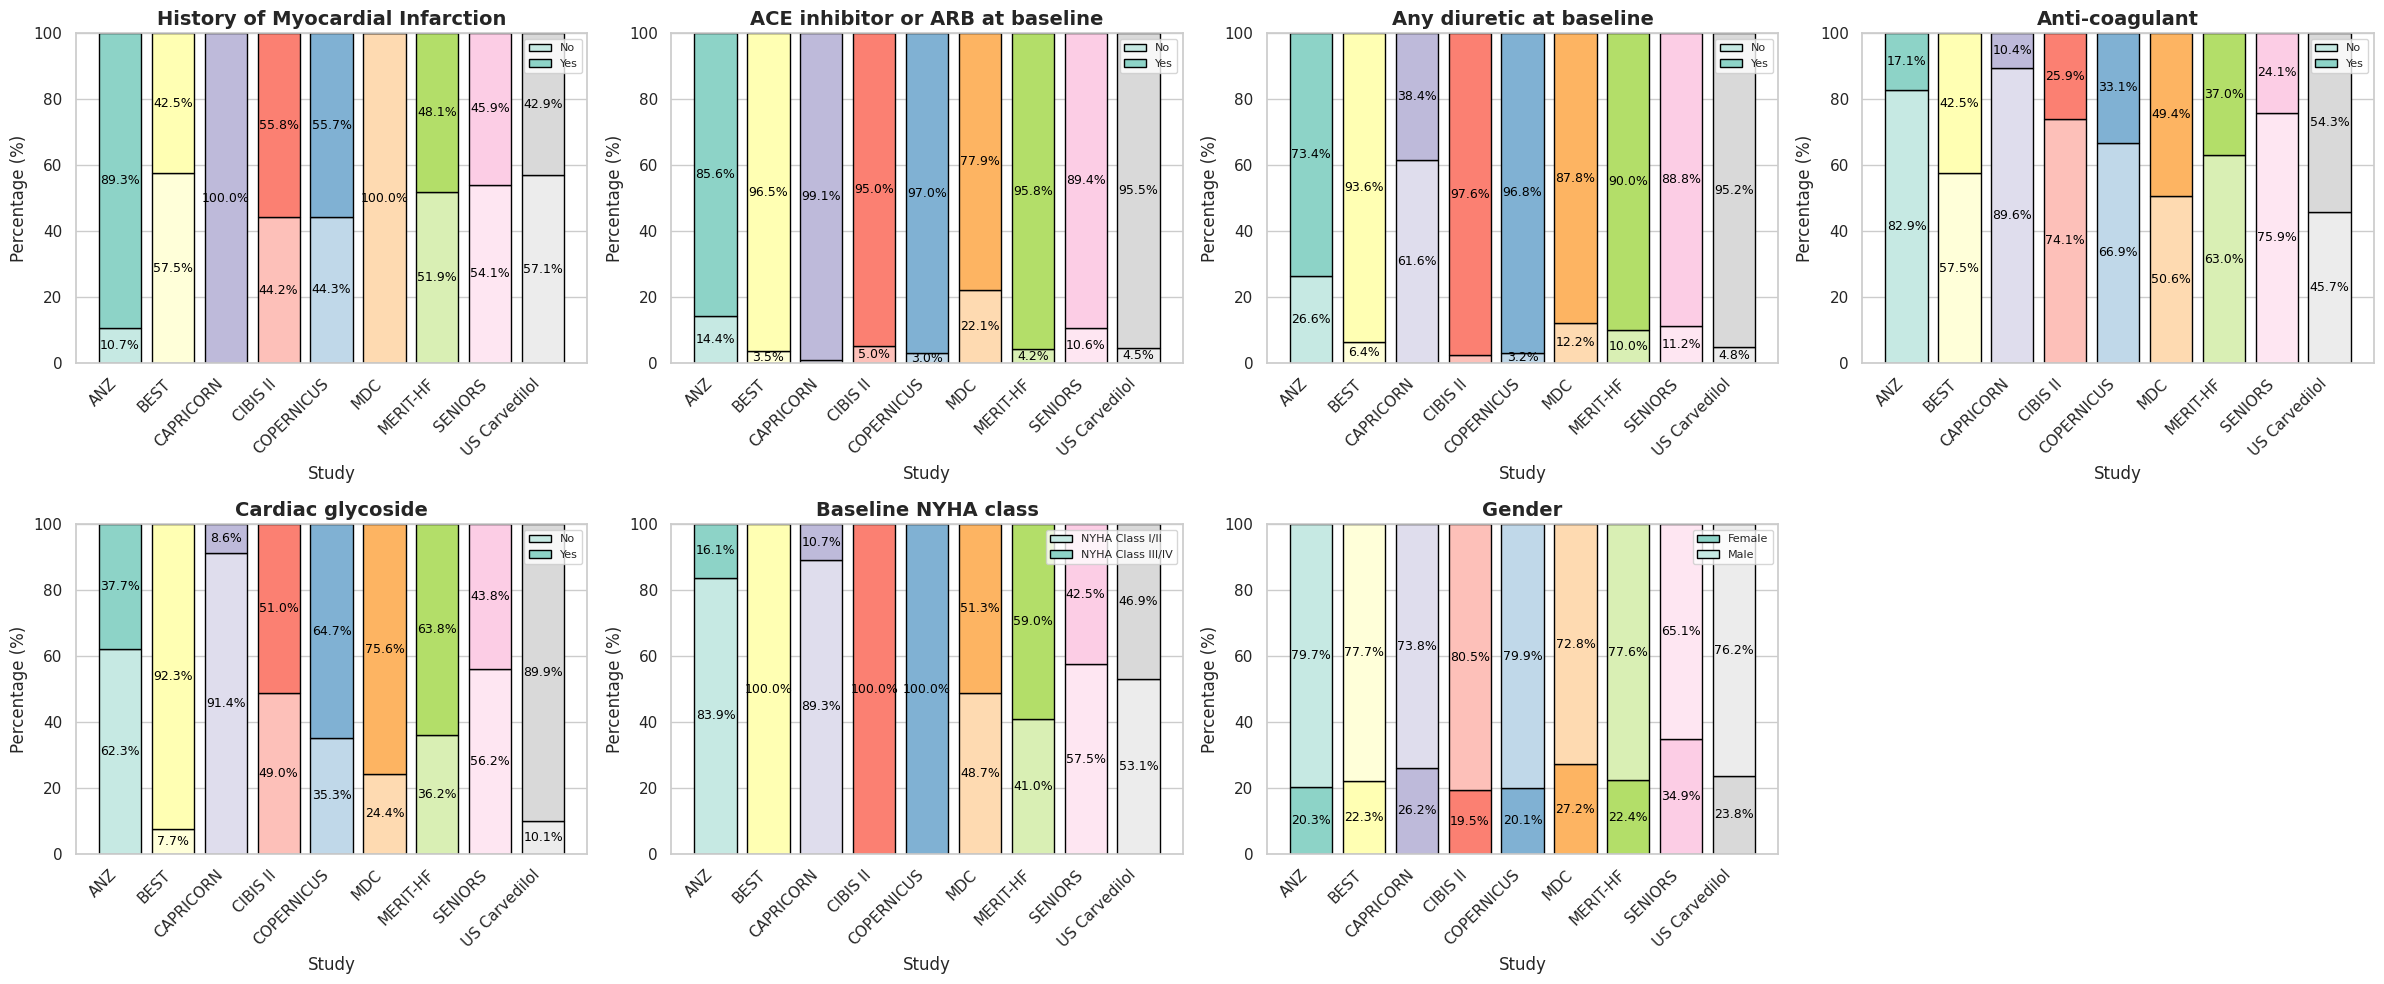

Categorical figure for slides saved to study_distributions/slides_categorical_study_colors.png


/tmp/ipykernel_90690/1261148767.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='study', y=var, ax=ax,
/tmp/ipykernel_90690/1261148767.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_90690/1261148767.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='study', y=var, ax=ax,
/tmp/ipykernel_90690/1261148767.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45

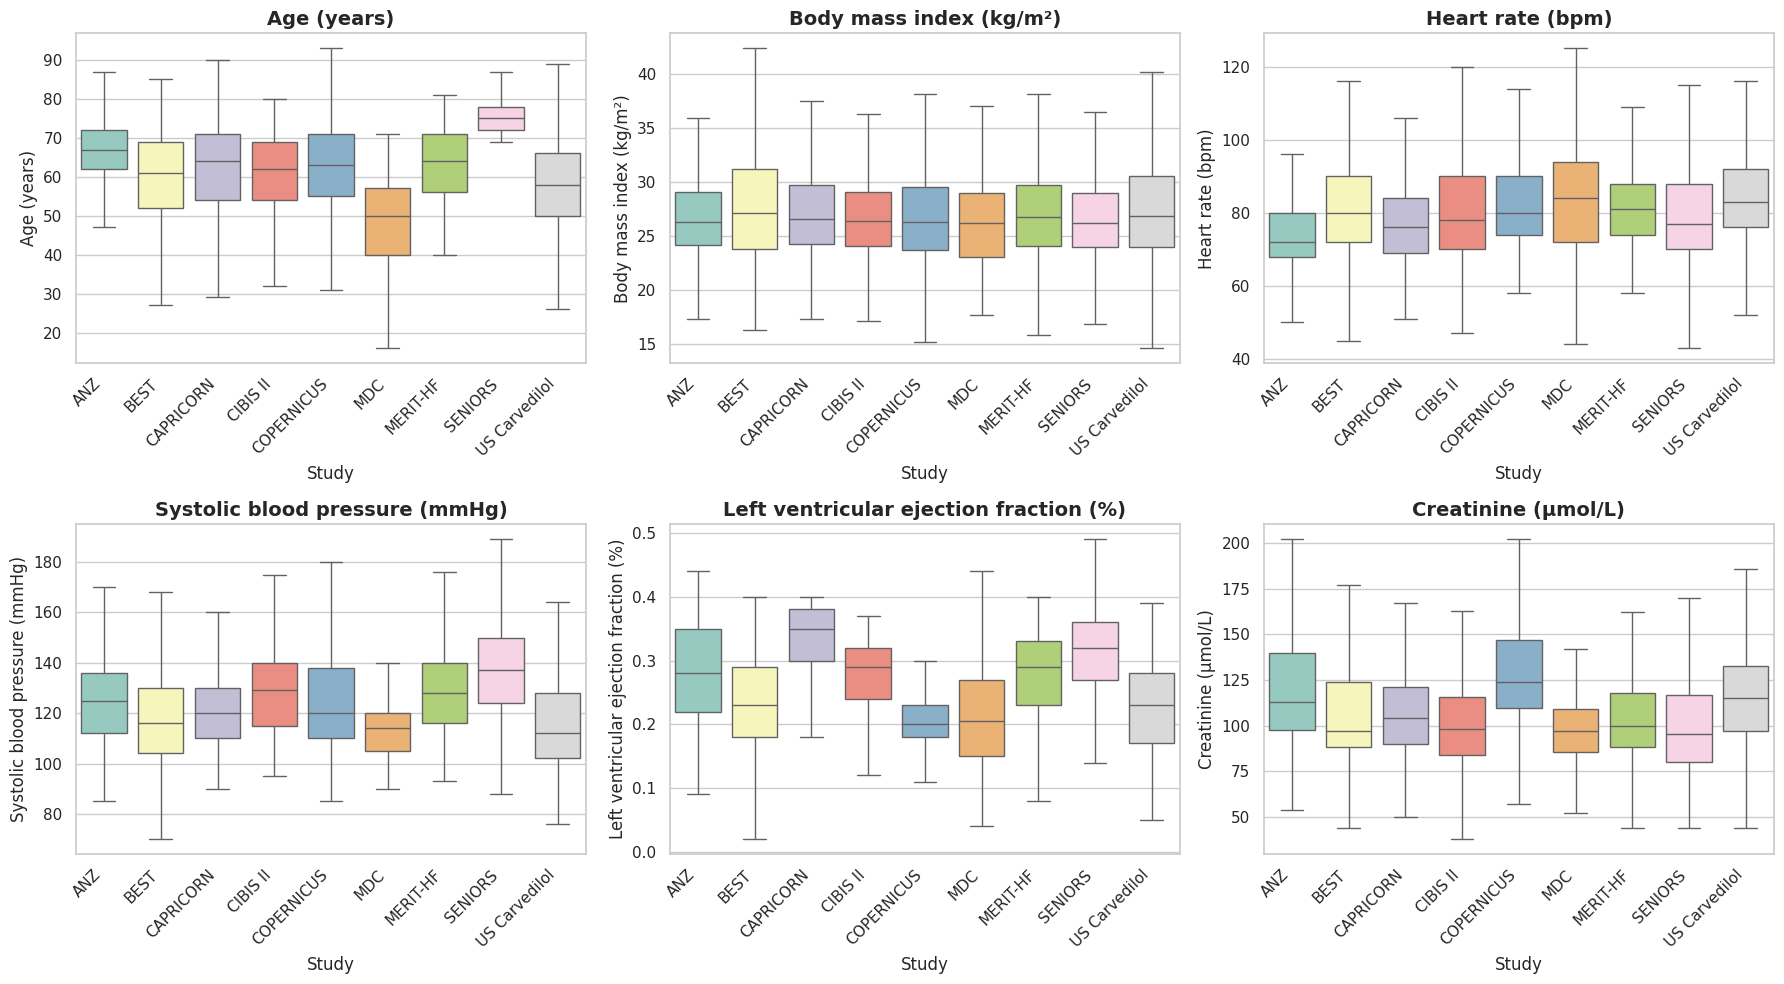

Continuous figure for slides saved to study_distributions/slides_continuous_study_colors.png


In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba

sns.set_theme(style="whitegrid")

output_dir = "study_distributions"
os.makedirs(output_dir, exist_ok=True)

# --- Variables & label map ---
continuous_vars = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_vars = ['mi', 'acearb', 'diur_any',
                    'anticoag', 'digoxin', 'nyhac2', 'gender']

label_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure (mmHg)',
    'hr': 'Heart rate (bpm)',
    'lvef': 'Left ventricular ejection fraction (%)',
    'creat': 'Creatinine (μmol/L)',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index (kg/m²)',
    'age': 'Age (years)',
    'gender': 'Gender'
}

# Assume cleaned_df is defined somewhere above this script
cleaned_df = cleaned_df.copy()

# Map gender and nyhac2 if present
if 'gender' in cleaned_df.columns:
    cleaned_df['gender'] = cleaned_df['gender'].map({0: 'Male', 1: 'Female'}).astype(str)
if 'nyhac2' in cleaned_df.columns:
    cleaned_df['nyhac2'] = cleaned_df['nyhac2'].map({
        0: 'NYHA Class I/II',
        1: 'NYHA Class III/IV'
    }).astype(str)

# Prepare study order and color map
study_order = sorted(cleaned_df['study'].dropna().unique())
study_palette = sns.color_palette("Set3", len(study_order))
study_color_map = dict(zip(study_order, study_palette))

class_map = {0: 'No', 1: 'Yes'}

# ----------- PLOT CATEGORICAL VARIABLES -----------

def plot_categorical(df, categorical_vars, study_order, study_color_map, label_map, output_dir):
    n_cat = len(categorical_vars)
    ncols = 4
    nrows = (n_cat + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axs = axs.flatten()

    for idx, var in enumerate(categorical_vars):
        ax = axs[idx]
        temp_df = df.copy()

        if var not in ['gender', 'nyhac2']:
            if temp_df[var].dropna().isin(class_map.keys()).all():
                temp_df[var] = temp_df[var].map(class_map).astype(str)
        else:
            temp_df[var] = temp_df[var].astype(str)

        counts = temp_df.groupby(['study', var]).size().unstack(fill_value=0)
        counts = counts.reindex(study_order)
        percents = counts.div(counts.sum(axis=1), axis=0) * 100

        bottom = np.zeros(len(percents))

        for class_val in sorted(percents.columns):
            colors = []
            for study in percents.index:
                base_color = study_color_map[study]
                alpha = 0.5 if class_val.lower() in ['no', 'male', 'nyha class i/ii'] else 1.0
                rgba = to_rgba(base_color, alpha=alpha)
                blended = [c*alpha + (1-alpha)*1 for c in rgba[:3]]
                colors.append(blended)

            bars = ax.bar(percents.index, percents[class_val], bottom=bottom,
                          color=colors, edgecolor='black', label=class_val)

            for bar, percent_val in zip(bars, percents[class_val]):
                if percent_val > 3:
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                            f"{percent_val:.1f}%", ha='center', va='center', fontsize=9, color='black')
            bottom += percents[class_val].values

        ax.set_title(f"{label_map.get(var, var)}", fontsize=14, fontweight='bold')
        ax.set_xlabel('Study')
        ax.set_ylabel('Percentage (%)')
        ax.set_ylim(0, 100)
        ax.set_xticks(np.arange(len(percents.index)))
        ax.set_xticklabels(percents.index, rotation=45, ha='right')
        ax.legend(title=None, fontsize=8, loc='upper right')

    # Remove empty axes if any
    for k in range(n_cat, len(axs)):
        fig.delaxes(axs[k])

    fig.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, "slides_categorical_study_colors.png")
    fig.savefig(save_path, dpi=300)
    print(f"Categorical figure for slides saved to {save_path}")

# ----------- PLOT CONTINUOUS VARIABLES -----------

def plot_continuous(df, continuous_vars, study_order, study_color_map, label_map, output_dir):
    n_cont = len(continuous_vars)
    ncols = 3
    nrows = (n_cont + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axs = axs.flatten()

    for idx, var in enumerate(continuous_vars):
        ax = axs[idx]
        sns.boxplot(data=df, x='study', y=var, ax=ax,
                    palette=study_color_map, showfliers=False,
                    order=study_order)

        ax.set_title(f"{label_map.get(var, var)}", fontsize=14, fontweight='bold')
        ax.set_xlabel('Study')
        ax.set_ylabel(label_map.get(var, var))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for k in range(n_cont, len(axs)):
        fig.delaxes(axs[k])

    fig.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, "slides_continuous_study_colors.png")
    fig.savefig(save_path, dpi=300)
    print(f"Continuous figure for slides saved to {save_path}")

# ----------- RUN BOTH PLOTS -----------

plot_categorical(cleaned_df, categorical_vars, study_order, study_color_map, label_map, output_dir)
plot_continuous(cleaned_df, continuous_vars, study_order, study_color_map, label_map, output_dir)


In [59]:
import pandas as pd
from tableone import TableOne

# --- Column setup ---
categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome', 'gender', 'nyhac2']
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
columns = categorical_cols + numerical_cols

# --- Pretty variable names for table ---
labels = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure (mmHg)',
    'hr': 'Heart rate (bpm)',
    'lvef': 'Left ventricular ejection fraction (%)',
    'creat': 'Creatinine (μmol/L)',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index (kg/m²)',
    'age': 'Age (years)',
    'gender': 'Gender',
    'ecgrhyt': 'ECG rhythm'
}

# --- Relabel binary columns ---
binary_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin']
for col in binary_cols:
    cleaned_df[col] = cleaned_df[col].map({0: 'No', 1: 'Yes'})

# NYHA Class
cleaned_df['nyhac2'] = cleaned_df['nyhac2'].map({
    0: 'NYHA Class I/II',
    1: 'NYHA Class III/IV'})

# Gender
cleaned_df['gender'] = cleaned_df['gender'].map({
    0: 'Male',
    1: 'Female'})

# Outcome label
cleaned_df['severe_outcome'] = cleaned_df['severe_outcome'].map({
    0: 'No Severe Outcome',
    1: 'Severe Outcome'
})

# --- Generate the table ---
table1 = TableOne(
    data=cleaned_df,
    columns=columns,
    categorical=categorical_cols,
    groupby='severe_outcome',
    pval=True,
    isnull=True,
    labels=labels,
    rename=labels  # also rename columns in output
)

# --- Print or export ---
print(table1)
# table1.to_csv("table1_final.csv")

                                                                    Grouped by severe_outcome                                                       
                                                                                      Missing       Overall No Severe Outcome Severe Outcome P-Value
n                                                                                                     16153              8974           7179        
History of Myocardial Infarction, n (%)           No                                            7346 (45.5)       4338 (48.3)    3008 (41.9)  <0.001
                                                  Yes                                           8807 (54.5)       4636 (51.7)    4171 (58.1)        
ACE inhibitor or ARB at baseline, n (%)           No                                              806 (5.0)         408 (4.5)      398 (5.5)   0.004
                                                  Yes                                          15347 (95.0

In [61]:
table1.to_csv("features_summary_tabel.csv")

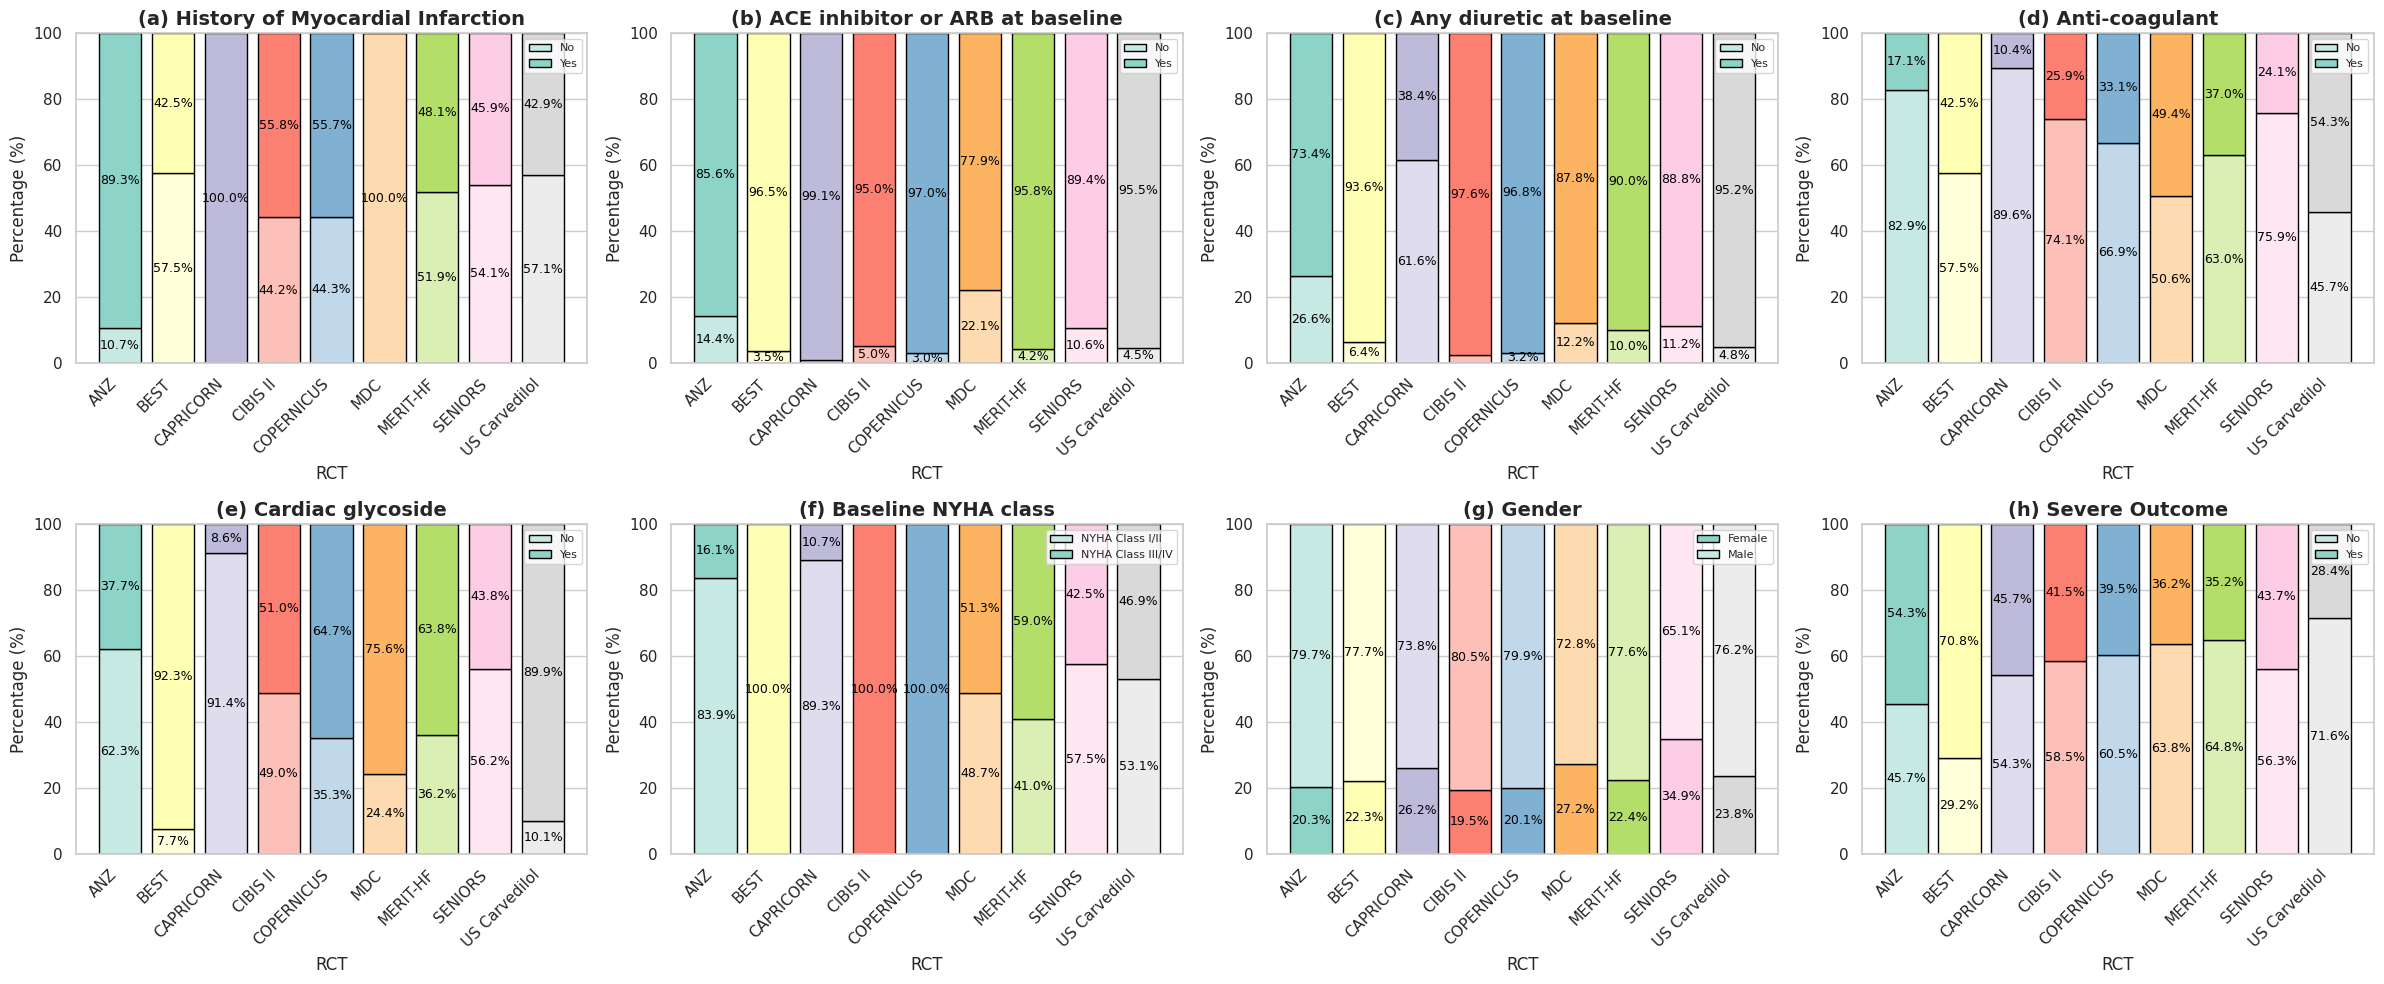

Categorical figure for slides saved to study_distributions/slides_categorical_rct_colors.png


/tmp/ipykernel_3549/3687781924.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='RCT', y=var, ax=ax,
/tmp/ipykernel_3549/3687781924.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_3549/3687781924.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='RCT', y=var, ax=ax,
/tmp/ipykernel_3549/3687781924.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='ri

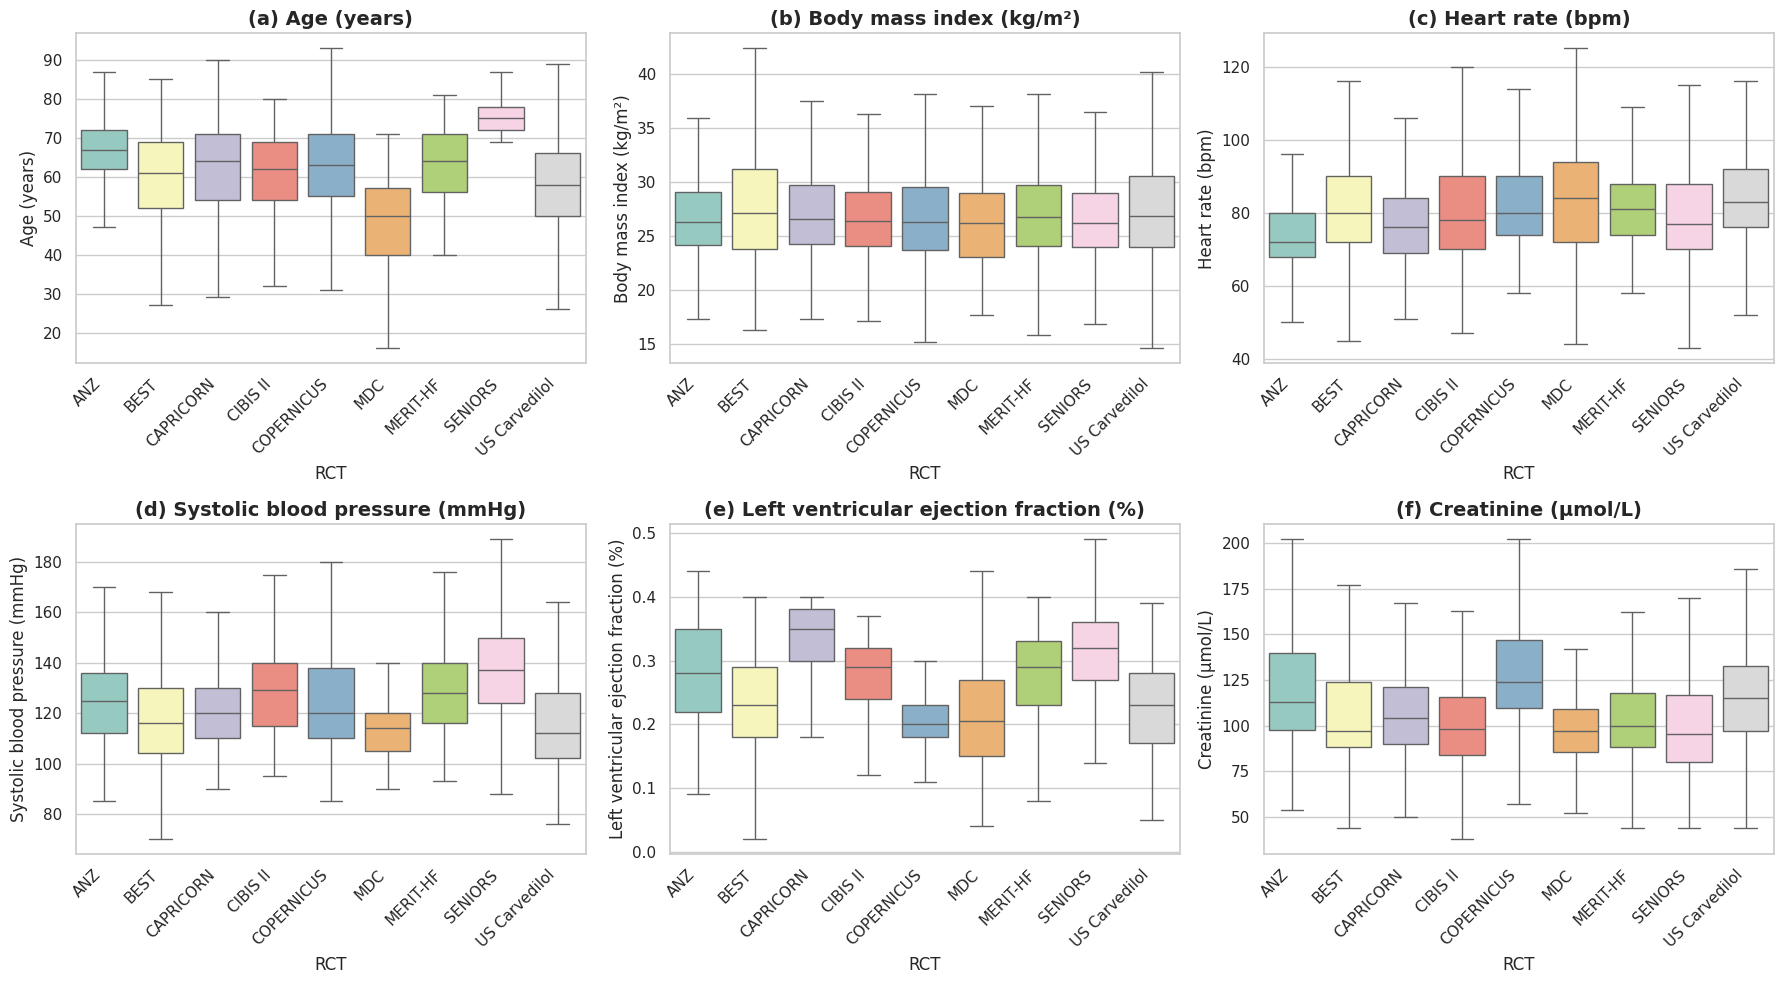

Continuous figure for slides saved to study_distributions/slides_continuous_rct_colors.pdf


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba
import string

sns.set_theme(style="whitegrid")

output_dir = "study_distributions"
os.makedirs(output_dir, exist_ok=True)

# --- Variables & label map ---
continuous_vars = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_vars = ['mi', 'acearb', 'diur_any',
                    'anticoag', 'digoxin', 'nyhac2', 'gender', 'severe_outcome']

label_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure (mmHg)',
    'hr': 'Heart rate (bpm)',
    'lvef': 'Left ventricular ejection fraction (%)',
    'creat': 'Creatinine (μmol/L)',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index (kg/m²)',
    'age': 'Age (years)',
    'gender': 'Gender',
    'severe_outcome': 'Severe Outcome'
}

# Assume cleaned_df is defined somewhere above this script
cleaned_df = cleaned_df.copy()

# Rename 'study' to 'RCT'
cleaned_df = cleaned_df.rename(columns={'study': 'RCT'})

# Map gender and nyhac2 if present
if 'gender' in cleaned_df.columns:
    cleaned_df['gender'] = cleaned_df['gender'].map({0: 'Male', 1: 'Female'}).astype(str)
if 'nyhac2' in cleaned_df.columns:
    cleaned_df['nyhac2'] = cleaned_df['nyhac2'].map({
        0: 'NYHA Class I/II',
        1: 'NYHA Class III/IV'
    }).astype(str)

# Prepare RCT order and color map
rct_order = sorted(cleaned_df['RCT'].dropna().unique())
rct_palette = sns.color_palette("Set3", len(rct_order))
rct_color_map = dict(zip(rct_order, rct_palette))

class_map = {0: 'No', 1: 'Yes'}

# ----------- PLOT CATEGORICAL VARIABLES -----------

def plot_categorical(df, categorical_vars, rct_order, rct_color_map, label_map, output_dir):
    n_cat = len(categorical_vars)
    ncols = 4
    nrows = (n_cat + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axs = axs.flatten()

    for idx, var in enumerate(categorical_vars):
        ax = axs[idx]
        temp_df = df.copy()

        if var not in ['gender', 'nyhac2']:
            if temp_df[var].dropna().isin(class_map.keys()).all():
                temp_df[var] = temp_df[var].map(class_map).astype(str)
        else:
            temp_df[var] = temp_df[var].astype(str)

        counts = temp_df.groupby(['RCT', var]).size().unstack(fill_value=0)
        counts = counts.reindex(rct_order)
        percents = counts.div(counts.sum(axis=1), axis=0) * 100

        bottom = np.zeros(len(percents))

        for class_val in sorted(percents.columns):
            colors = []
            for rct in percents.index:
                base_color = rct_color_map[rct]
                alpha = 0.5 if class_val.lower() in ['no', 'male', 'nyha class i/ii'] else 1.0
                rgba = to_rgba(base_color, alpha=alpha)
                blended = [c*alpha + (1-alpha)*1 for c in rgba[:3]]
                colors.append(blended)

            bars = ax.bar(percents.index, percents[class_val], bottom=bottom,
                          color=colors, edgecolor='black', label=class_val)

            for bar, percent_val in zip(bars, percents[class_val]):
                if percent_val > 3:
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                            f"{percent_val:.1f}%", ha='center', va='center', fontsize=9, color='black')
            bottom += percents[class_val].values

        letter = string.ascii_lowercase[idx]
        ax.set_title(f"({letter}) {label_map.get(var, var)}", fontsize=14, fontweight='bold')
        ax.set_xlabel('RCT')
        ax.set_ylabel('Percentage (%)')
        ax.set_ylim(0, 100)
        ax.set_xticks(np.arange(len(percents.index)))
        ax.set_xticklabels(percents.index, rotation=45, ha='right')
        ax.legend(title=None, fontsize=8, loc='upper right')

    for k in range(n_cat, len(axs)):
        fig.delaxes(axs[k])

    fig.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, "slides_categorical_rct_colors.png")
    fig.savefig(save_path, dpi=300)
    print(f"Categorical figure for slides saved to {save_path}")

# ----------- PLOT CONTINUOUS VARIABLES -----------

def plot_continuous(df, continuous_vars, rct_order, rct_color_map, label_map, output_dir):
    n_cont = len(continuous_vars)
    ncols = 3
    nrows = (n_cont + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axs = axs.flatten()

    for idx, var in enumerate(continuous_vars):
        ax = axs[idx]
        sns.boxplot(data=df, x='RCT', y=var, ax=ax,
                    palette=rct_color_map, showfliers=False,
                    order=rct_order)

        letter = string.ascii_lowercase[idx]
        ax.set_title(f"({letter}) {label_map.get(var, var)}", fontsize=14, fontweight='bold')
        ax.set_xlabel('RCT')
        ax.set_ylabel(label_map.get(var, var))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for k in range(n_cont, len(axs)):
        fig.delaxes(axs[k])

    fig.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, "slides_continuous_rct_colors.pdf")
    fig.savefig(save_path, dpi=300)
    print(f"Continuous figure for slides saved to {save_path}")

# ----------- RUN BOTH PLOTS -----------

plot_categorical(cleaned_df, categorical_vars, rct_order, rct_color_map, label_map, output_dir)
plot_continuous(cleaned_df, continuous_vars, rct_order, rct_color_map, label_map, output_dir)


In [8]:
def plot_categorical(df, categorical_vars, rct_order, rct_color_map, label_map, output_dir):
    n_cat = len(categorical_vars)
    ncols = 4
    nrows = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))  # 6x6 per plot = square
    axs = axs.flatten()

    for idx, var in enumerate(categorical_vars):
        ax = axs[idx]
        temp_df = df.copy()

        if var not in ['gender', 'nyhac2']:
            if temp_df[var].dropna().isin(class_map.keys()).all():
                temp_df[var] = temp_df[var].map(class_map).astype(str)
        else:
            temp_df[var] = temp_df[var].astype(str)

        counts = temp_df.groupby(['RCT', var]).size().unstack(fill_value=0)
        counts = counts.reindex(rct_order)
        percents = counts.div(counts.sum(axis=1), axis=0) * 100

        bottom = np.zeros(len(percents))

        for class_val in sorted(percents.columns):
            colors = []
            for rct in percents.index:
                base_color = rct_color_map[rct]
                alpha = 0.5 if class_val.lower() in ['no', 'male', 'nyha class i/ii'] else 1.0
                rgba = to_rgba(base_color, alpha=alpha)
                blended = [c*alpha + (1-alpha)*1 for c in rgba[:3]]
                colors.append(blended)

            bars = ax.bar(percents.index, percents[class_val], bottom=bottom,
                          color=colors, edgecolor='black', label=class_val)

            for bar, percent_val in zip(bars, percents[class_val]):
                if percent_val > 3:
                    ax.text(
                        bar.get_x() + bar.get_width()/2,
                        bar.get_y() + bar.get_height()/2,
                        f"{int(round(percent_val))}%",  # Rounded to integer
                        ha='center',
                        va='center',
                        fontsize=10
                    )
            bottom += percents[class_val].values

        letter = string.ascii_lowercase[idx]
        ax.set_title(f"({letter}) {label_map.get(var, var)}", fontsize=14, fontweight='bold')
        ax.set_xlabel('RCT')
        ax.set_ylabel('Percentage (%)')
        ax.set_ylim(0, 100)
        ax.set_xticks(np.arange(len(percents.index)))
        ax.set_xticklabels(percents.index, rotation=45, ha='right')

        # Enlarge and position the legend
        ax.legend(title=None, fontsize=11, loc='upper right')

    for k in range(n_cat, len(axs)):
        fig.delaxes(axs[k])

    fig.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, "slides_categorical_rct_colors.png")
    fig.savefig(save_path, dpi=300)
    print(f"Categorical figure for slides saved to {save_path}")

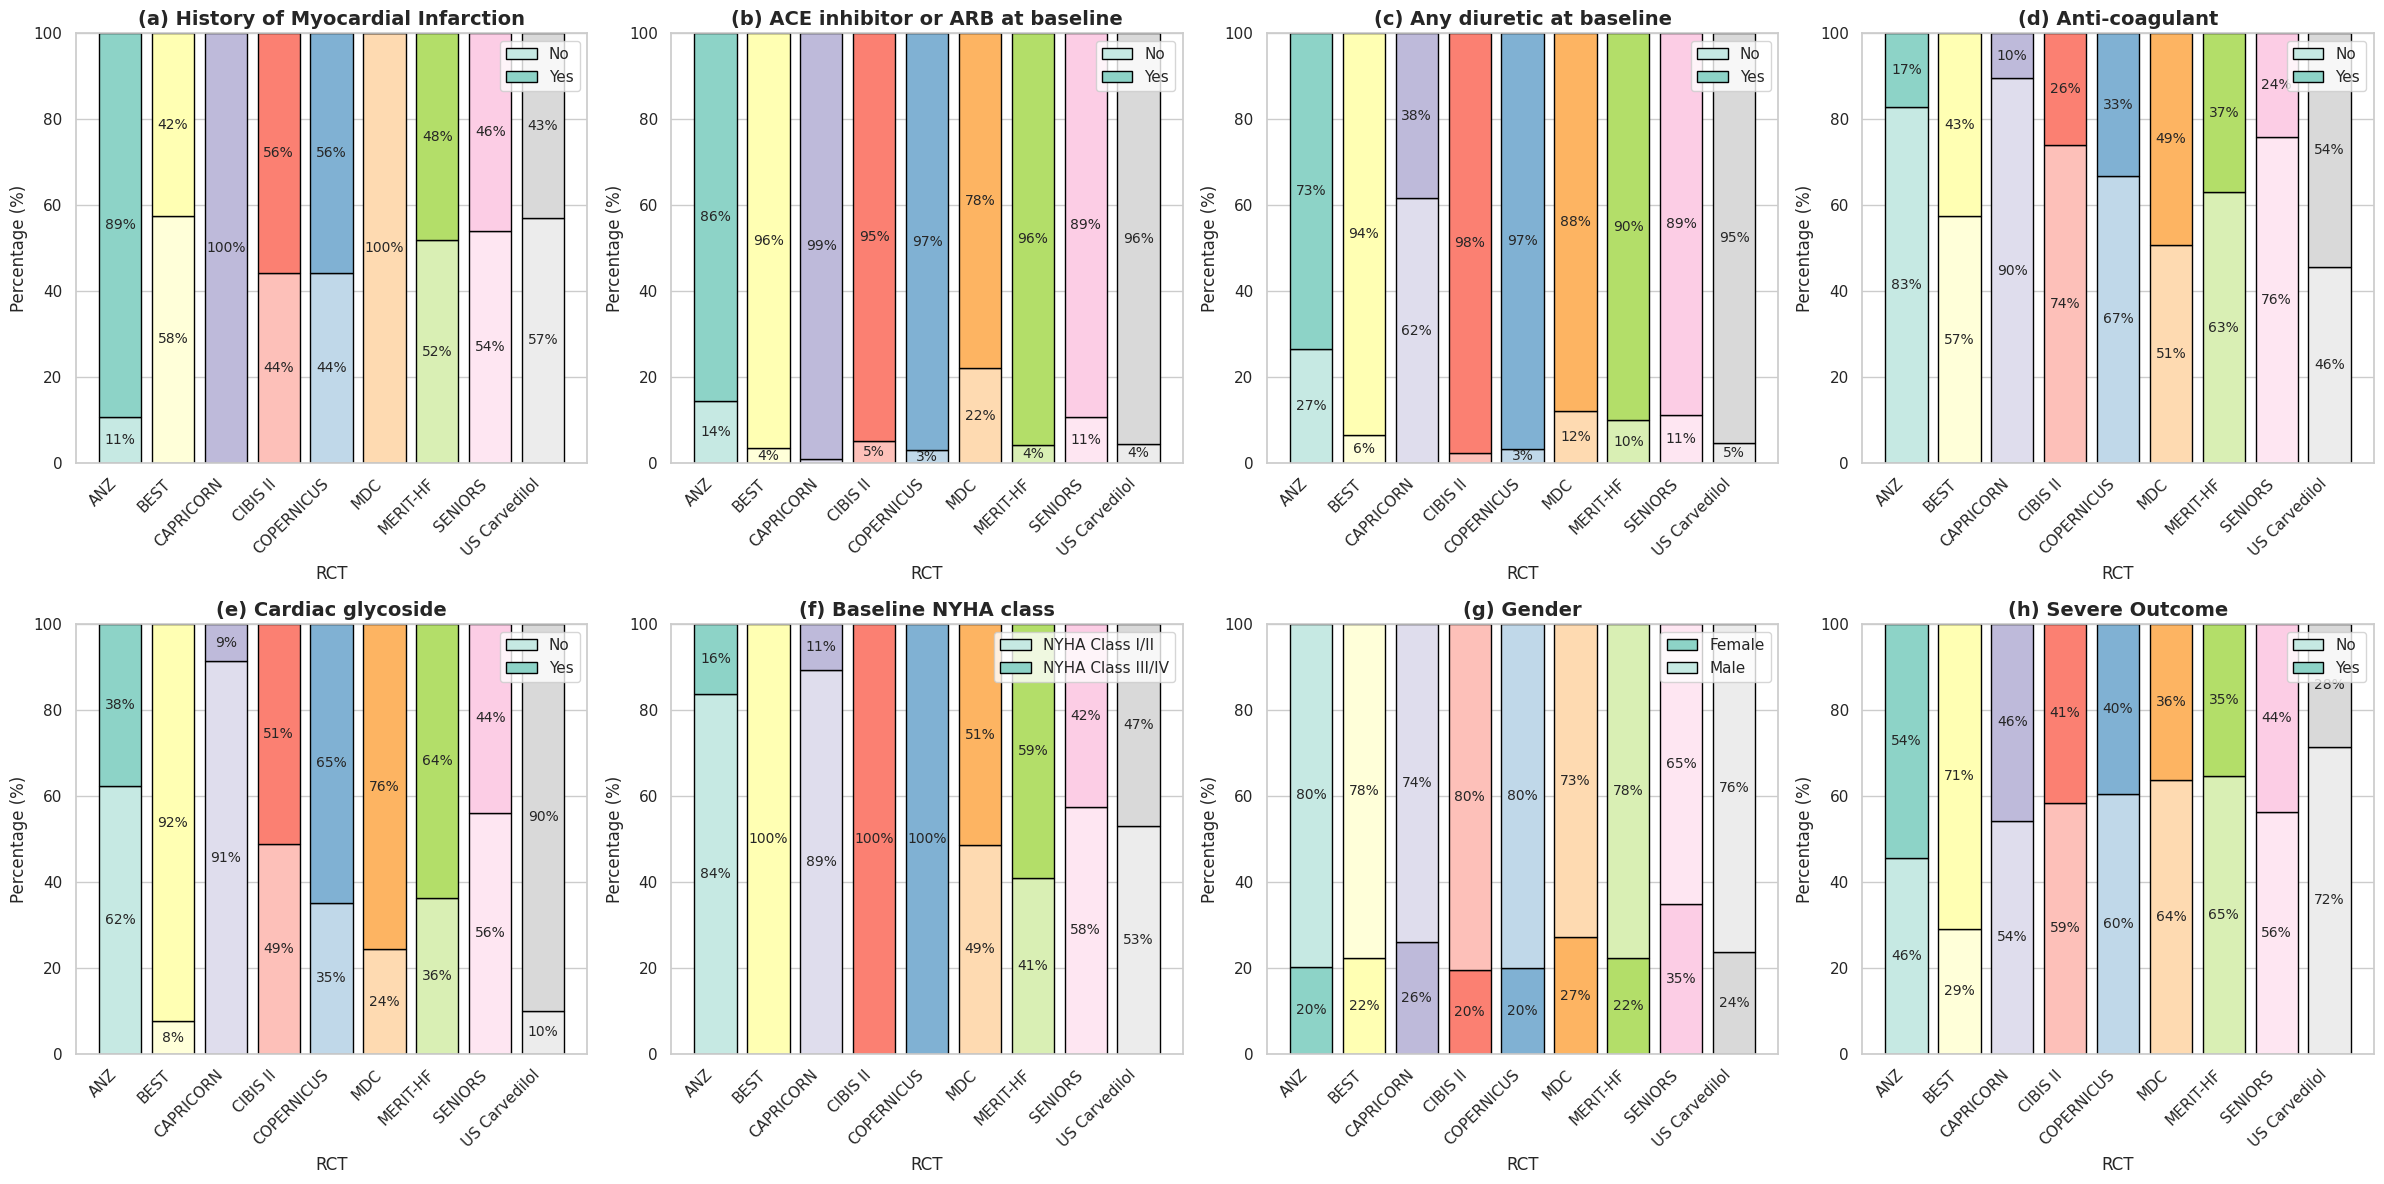

Categorical figure for slides saved to study_distributions/slides_categorical_rct_colors.pdf


In [13]:
plot_categorical(cleaned_df, categorical_vars, rct_order, rct_color_map, label_map, output_dir)

In [12]:
def plot_categorical(df, categorical_vars, rct_order, rct_color_map, label_map, output_dir):
    n_cat = len(categorical_vars)
    ncols = 4
    nrows = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))  # 6x6 per plot = square
    axs = axs.flatten()

    for idx, var in enumerate(categorical_vars):
        ax = axs[idx]
        temp_df = df.copy()

        if var not in ['gender', 'nyhac2']:
            if temp_df[var].dropna().isin(class_map.keys()).all():
                temp_df[var] = temp_df[var].map(class_map).astype(str)
        else:
            temp_df[var] = temp_df[var].astype(str)

        counts = temp_df.groupby(['RCT', var]).size().unstack(fill_value=0)
        counts = counts.reindex(rct_order)
        percents = counts.div(counts.sum(axis=1), axis=0) * 100

        bottom = np.zeros(len(percents))

        for class_val in sorted(percents.columns):
            colors = []
            for rct in percents.index:
                base_color = rct_color_map[rct]
                alpha = 0.5 if class_val.lower() in ['no', 'male', 'nyha class i/ii'] else 1.0
                rgba = to_rgba(base_color, alpha=alpha)
                blended = [c*alpha + (1-alpha)*1 for c in rgba[:3]]
                colors.append(blended)

            bars = ax.bar(percents.index, percents[class_val], bottom=bottom,
                          color=colors, edgecolor='black', label=class_val)

            for bar, percent_val in zip(bars, percents[class_val]):
                if percent_val > 3:
                    ax.text(
                        bar.get_x() + bar.get_width()/2,
                        bar.get_y() + bar.get_height()/2,
                        f"{int(round(percent_val))}%",  # Rounded to integer
                        ha='center',
                        va='center',
                        fontsize=10
                    )
            bottom += percents[class_val].values

        letter = string.ascii_lowercase[idx]
        ax.set_title(f"({letter}) {label_map.get(var, var)}", fontsize=14, fontweight='bold')
        ax.set_xlabel('RCT')
        ax.set_ylabel('Percentage (%)')
        ax.set_ylim(0, 100)
        ax.set_xticks(np.arange(len(percents.index)))
        ax.set_xticklabels(percents.index, rotation=45, ha='right')

        # Enlarge and position the legend
        ax.legend(title=None, fontsize=11, loc='upper right')

    for k in range(n_cat, len(axs)):
        fig.delaxes(axs[k])

    fig.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, "slides_categorical_rct_colors.pdf")
    fig.savefig(save_path, dpi=300)
    print(f"Categorical figure for slides saved to {save_path}")


/tmp/ipykernel_206122/2330071067.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='RCT', y=var, ax=ax,
/tmp/ipykernel_206122/2330071067.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_206122/2330071067.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='RCT', y=var, ax=ax,
/tmp/ipykernel_206122/2330071067.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha

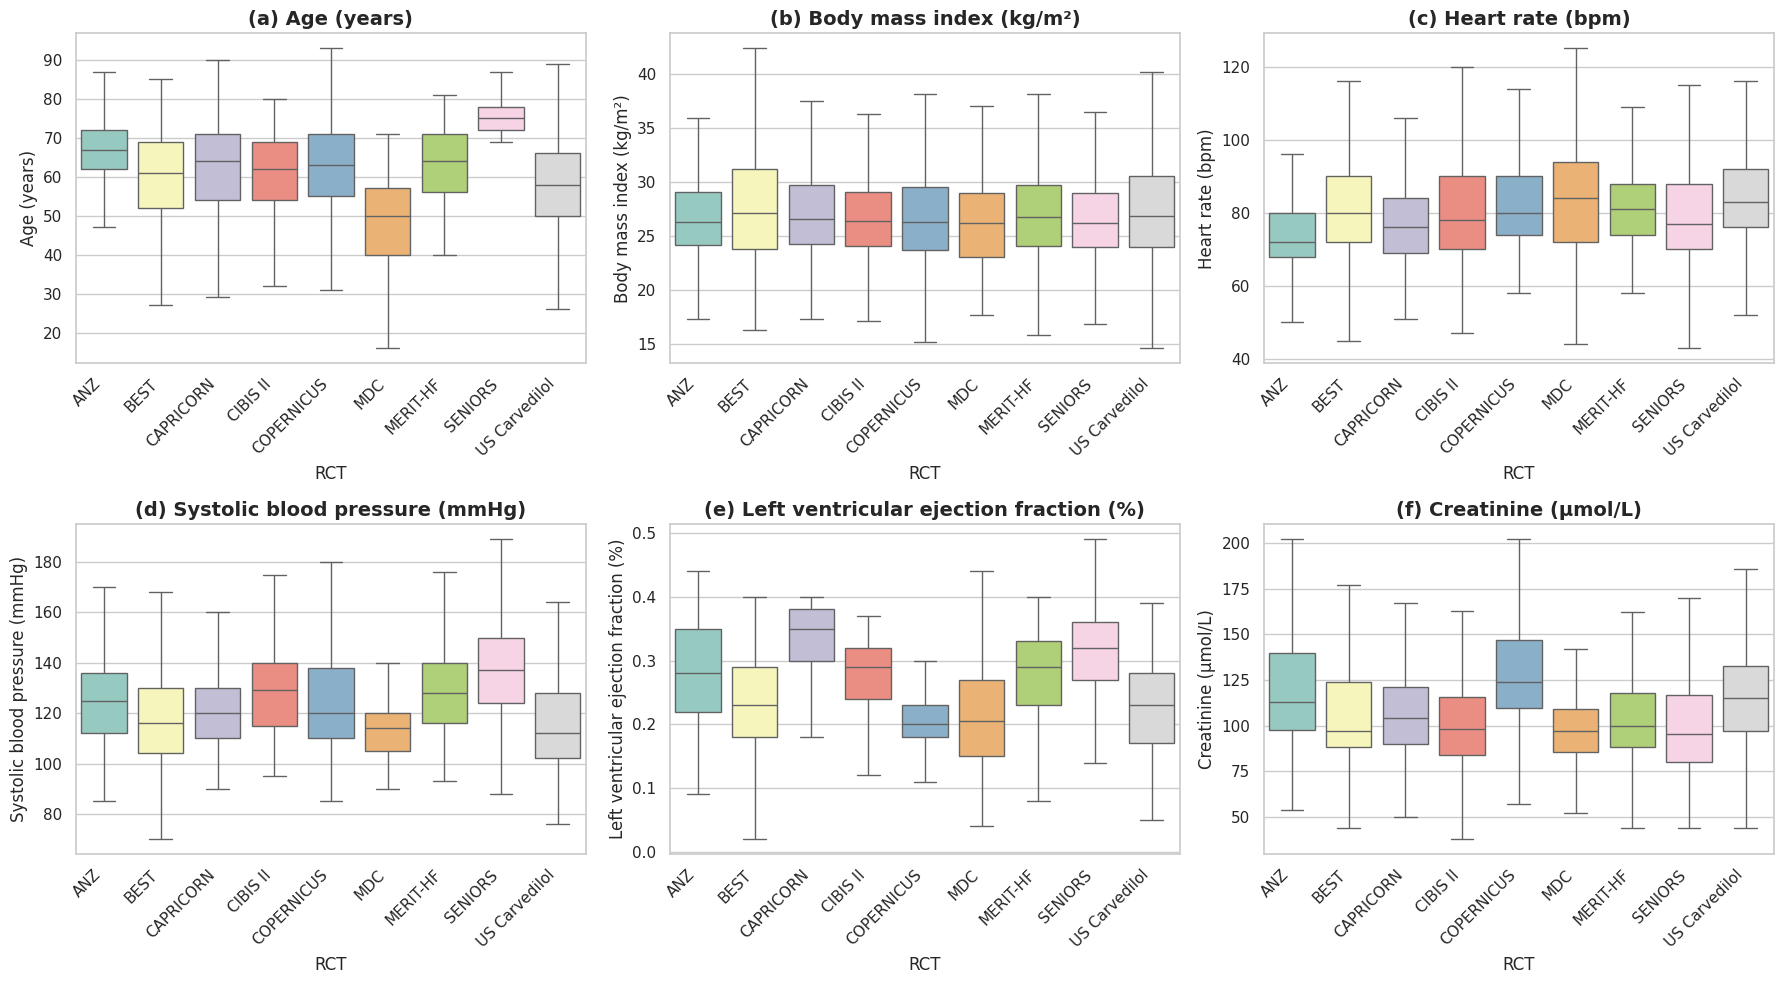

Continuous figure for slides saved to study_distributions/slides_continuous_rct_colors.pdf


In [17]:
# ----------- PLOT CONTINUOUS VARIABLES -----------

def plot_continuous(df, continuous_vars, rct_order, rct_color_map, label_map, output_dir):
    n_cont = len(continuous_vars)
    ncols = 3
    nrows = (n_cont + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axs = axs.flatten()

    for idx, var in enumerate(continuous_vars):
        ax = axs[idx]
        sns.boxplot(data=df, x='RCT', y=var, ax=ax,
                    palette=rct_color_map, showfliers=False,
                    order=rct_order)

        letter = string.ascii_lowercase[idx]
        ax.set_title(f"({letter}) {label_map.get(var, var)}", fontsize=14, fontweight='bold')
        ax.set_xlabel('RCT')
        ax.set_ylabel(label_map.get(var, var))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for k in range(n_cont, len(axs)):
        fig.delaxes(axs[k])

    fig.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, "slides_continuous_rct_colors.pdf")
    fig.savefig(save_path, dpi=300)
    print(f"Continuous figure for slides saved to {save_path}")

# ----------- RUN BOTH PLOTS -----------

plot_continuous(cleaned_df, continuous_vars, rct_order, rct_color_map, label_map, output_dir)